In [1]:
import os
import numpy as np
import glob
from skimage.io import imread,imsave
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import random
import tqdm
import keras
from tqdm.notebook import tqdm_notebook
import yaml
from dvclive.keras import DVCLiveCallback
from loss import tversky_loss, focal_tversky,sdice_loss, dice_loss,log_cosh_dice_loss

In [2]:
tf.config.list_physical_devices('GPU')
params = yaml.safe_load(open("params.yaml"))['model_params']

In [3]:
# Specify the size of patches and number of classes expected by the model.
image_size = params['Image_patch_size']
mask_size = params['Mask_patch_size']
num_class = params['Number_of_classes']
lr = params['Learning_rate']
batchsize = params['Batch_size']
optimizer = params['Optimizer']
epochs = params['Epochs']

In [4]:
AUTOTUNE = tf.data.AUTOTUNE
PATH = 'tfrecords/'
BATCH_SIZE = batchsize

In [5]:
FILENAMES = tf.io.gfile.glob(PATH +"*large_images.tfrecords")
split_ind = int(0.7 * len(FILENAMES))
TRAINING_FILENAMES, VALID_FILENAMES = FILENAMES[:split_ind], FILENAMES[split_ind:]
print("Train TFRecord Files:", len(TRAINING_FILENAMES))
print("Validation TFRecord Files:", len(VALID_FILENAMES))

Train TFRecord Files: 10
Validation TFRecord Files: 5


In [6]:
def read_tfrecord(example):
    tfrecord_format = (
        {
         "image":tf.io.FixedLenFeature(shape=[*image_size], dtype=tf.float32),
         "mask":tf.io.FixedLenFeature(shape=[*mask_size], dtype=tf.float32)
        }
    )
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = example["image"]
    mask = example["mask"]
    mask = tf.one_hot(tf.cast(mask, tf.uint8), 2)
    return image,mask

In [7]:
from functools import partial

In [8]:
def load_dataset(filenames):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable order, increase speed
    dataset = tf.data.TFRecordDataset(
        filenames
    )  # automatically interleaves reads from multiple files
    dataset = dataset.with_options(
        ignore_order
    )  # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(
        partial(read_tfrecord), num_parallel_calls=AUTOTUNE
    )
    # returns a dataset of (image, label) pairs if labeled=True or just images if labeled=False
    return dataset

In [9]:
seed=42

In [10]:
def augmentation(image, mask):
    # both use the same seed, so they'll make the same random changes
    flip_image = tf.image.random_flip_left_right(image,seed=seed)
    flip_mask = tf.image.random_flip_left_right(mask,seed=seed)
    # Other transformations...
    return flip_image, flip_mask

In [11]:
def get_dataset(filenames):
    dataset = tf.data.Dataset.range(10)
    dataset = load_dataset(filenames).cache().repeat()
    # to avoid data loss error
    dataset = dataset.apply(tf.data.experimental.ignore_errors())
    dataset = dataset.shuffle(2048)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

In [12]:
train_dataset = get_dataset(TRAINING_FILENAMES)
valid_dataset = get_dataset(VALID_FILENAMES)

  0%|          | 0/3 [00:00<?, ?it/s]

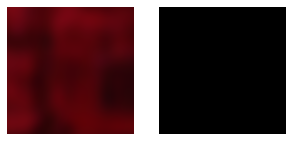

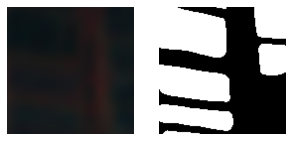

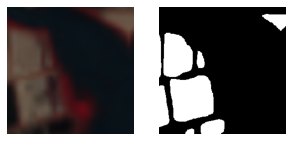

In [13]:
image_batch, label_batch = next(iter(train_dataset))
for i in tqdm_notebook(range(3)):
    image = image_batch[i]
    mask = label_batch[i]
    #Convert categorical to integer for visualization
    mask = np.argmax(mask, axis=2)
    plt.figure(figsize=(5,5))
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0:3])
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.show()

  0%|          | 0/3 [00:00<?, ?it/s]

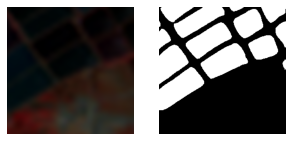

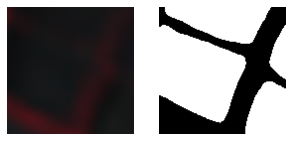

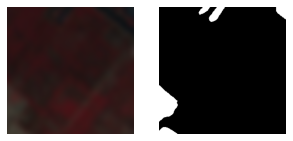

In [14]:
testimage_batch, label_batch = next(iter(valid_dataset))
for i in tqdm_notebook(range(3)):
    image = testimage_batch[i]
    mask = label_batch[i]
    #Convert categorical to integer for visualization
    mask = np.argmax(mask, axis=2)
    plt.figure(figsize=(5,5))
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0:3])
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.show()

In [15]:
# GPUS = ["GPU:0","GPU:1","GPU:2","GPU:3"]
# strategy = tf.distribute.MirroredStrategy( GPUS )
# print('Number of devices: %d' % strategy.num_replicas_in_sync)

In [16]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


Number of devices: 4


In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import AveragePooling2D, Conv2DTranspose, Concatenate, Input, GlobalAveragePooling2D, Dense, Multiply
from keras.applications.resnet import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, UpSampling2D

In [18]:
# input dimensions, no. of channels, and no. of classes for the model
IMG_HEIGHT = image_batch.shape[1]
IMG_WIDTH  = image_batch.shape[2]
IMG_CHANNELS = image_batch.shape[3]
n_classes=num_class

In [19]:
def SqueezeAndExcitation(inputs, ratio=8):
    
    b, h, w, c = inputs.shape
    
    x = GlobalAveragePooling2D()(inputs)
    x = Dense(c//ratio, activation='relu', use_bias=False)(x)
    x = Dense(c, activation='sigmoid', use_bias=False)(x)
    
    x = Multiply()([inputs, x])
    
    return x


def ASPP(image_features):

    shape = image_features.shape

    y_pool = AveragePooling2D(pool_size=(shape[1], shape[2]))(image_features)
    y_pool = Conv2D(filters=128, kernel_size=1, padding='same', use_bias=False)(y_pool)
    y_pool = BatchNormalization(name=f'bn_1')(y_pool)
    y_pool = Activation('relu', name=f'relu_1')(y_pool)
    y_pool = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y_pool)

    y_1 = Conv2D(filters=128, kernel_size=1, padding='same', use_bias=False)(image_features)
    y_1 = BatchNormalization(name=f'bn_2')(y_1)
    y_1 = Activation('relu', name=f'relu_2')(y_1)

    y_6 = Conv2D(filters=128, kernel_size=3, padding='same', dilation_rate = 6,use_bias=False)(image_features)
    y_6 = BatchNormalization(name=f'bn_3')(y_6)
    y_6 = Activation('relu', name=f'relu_3')(y_6)

    y_12 = Conv2D(filters=128, kernel_size=1, padding='same', dilation_rate = 12,use_bias=False)(image_features)
    y_12 = BatchNormalization(name=f'bn_4')(y_12)
    y_12 = Activation('relu', name=f'relu_4')(y_12)

    y_18 = Conv2D(filters=128, kernel_size=3, padding='same', dilation_rate = 6,use_bias=False)(image_features)
    y_18 = BatchNormalization(name=f'bn_5')(y_18)
    y_18 = Activation('relu', name=f'relu_5')(y_18)

    y_c = Concatenate()([y_pool, y_1, y_6, y_12, y_18])

    y = Conv2D(filters=128, kernel_size=1, padding='same', use_bias=False)(y_c)
    y = BatchNormalization(name=f'bn_6')(y)
    y = Activation('relu', name=f'relu_6')(y)

    return y

In [20]:
def DeepLabV3PlusSE(inputs, classes=1):

    inputs = Input(inputs)

    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)
    high_level_image_features = base_model.get_layer('conv4_block6_add').output
    high_level_image_features = SqueezeAndExcitation(high_level_image_features, ratio=16)
    
    x_a = ASPP(high_level_image_features)
    x_a = SqueezeAndExcitation(x_a, ratio=16)
    x_a = UpSampling2D(size=4, interpolation='bilinear')(x_a)

    low_level_image_features = base_model.get_layer('conv2_block3_add').output
    low_level_image_features = SqueezeAndExcitation(low_level_image_features, ratio=16)

    x_b = Conv2D(filters=256, kernel_size=1, padding='same', use_bias=False)(low_level_image_features)
    x_b = BatchNormalization(name=f'bn_7')(x_b)
    x_b = Activation('relu', name=f'relu_7')(x_b)

    x = Concatenate()([x_a, x_b])

    x = Conv2D(filters=256, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization(name=f'bn_8')(x)
    x = Activation('relu', name=f'relu_8')(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization(name=f'bn_9')(x)
    x = Activation('relu', name=f'relu_9')(x)

    x = UpSampling2D(size=4, interpolation='bilinear')(x)

    """ Outputs """
    x = Conv2D(classes, (1, 1), name='output_layer')(x)
    
    if classes == 1:
      x = Activation('sigmoid')(x)
    else:
      x = Activation('softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    
    return model

In [21]:
loss = params['Loss']
if loss == 'sdice_loss':
    with strategy.scope():
        model = DeepLabV3PlusSE((IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS),n_classes)
        model.compile(
        optimizer=optimizer,
        loss=sdice_loss,
        metrics=[[tf.keras.metrics.OneHotIoU(num_classes=2,target_class_ids=[0,1]),tf.keras.metrics.Precision()\
            ,tf.keras.metrics.Recall()]]
        )
elif loss == 'focal_tversky':
    with strategy.scope():
        model = DeepLabV3PlusSE((IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS),n_classes)
        model.compile(
        optimizer=optimizer,
        loss=focal_tversky,
        metrics=[[tf.keras.metrics.OneHotIoU(num_classes=2,target_class_ids=[0,1]),tf.keras.metrics.Precision()\
            ,tf.keras.metrics.Recall()]]
        )
elif loss == 'tversky_loss':
    with strategy.scope():
        model = DeepLabV3PlusSE((IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS),n_classes)
        model.compile(
        optimizer=optimizer,
        loss=tversky_loss,
        metrics=[[tf.keras.metrics.OneHotIoU(num_classes=2,target_class_ids=[0,1]),tf.keras.metrics.Precision()\
            ,tf.keras.metrics.Recall()]]
        )
elif loss == 'log_cosh_dice_loss':
    with strategy.scope():
        model = DeepLabV3PlusSE((IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS),n_classes)
        model.compile(
        optimizer=optimizer,
        loss=log_cosh_dice_loss,
        metrics=[[tf.keras.metrics.OneHotIoU(num_classes=2,target_class_ids=[0,1]),tf.keras.metrics.Precision()\
            ,tf.keras.metrics.Recall()]]
        )

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [22]:
# calculation of steps per epoch for traning and validation
filespershard = 500
number_of_shards = len(glob.glob(PATH+'*.tfrecords'))
steps_per_epoch = (number_of_shards*filespershard*0.7)// BATCH_SIZE
val_steps_per_epoch = (number_of_shards*filespershard*0.3)//BATCH_SIZE

In [23]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger,LearningRateScheduler,TensorBoard

In [24]:
#ModelCheckpoint callback saves a model at some interval. 
checkpoint_path = 'model_checkpoint/'
os.makedirs(checkpoint_path, exist_ok=True)
filepath=checkpoint_path+"resenet50_deeplabv3plus_SE_v5_sdice_loss.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_one_hot_io_u', verbose=1, save_best_only=True, mode='max')

In [25]:
# earlystop for stopping the model when there is no improvement
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
log_csv = CSVLogger('/home/ubuntu/Notebooks for Unet_training/models for deeplab+SE v5/tversky-logs/sdice_lossv1.csv', separator=',', append=False)

In [26]:
epochs=epochs
learning_rate = lr
decay_rate = learning_rate / epochs
def exp_decay(epoch):
    lrate = learning_rate * np.exp(-decay_rate*epoch)
    return lrate

In [27]:
lr_rate = LearningRateScheduler(exp_decay)

In [28]:
callbacks_list = [checkpoint,early_stop,lr_rate,DVCLiveCallback(dir='evaluation')]

In [29]:
%%time
history=model.fit(train_dataset,
          steps_per_epoch=steps_per_epoch,
          epochs=epochs,
          verbose=1,
          validation_data=valid_dataset,
          validation_steps=val_steps_per_epoch,
          callbacks=callbacks_list,
          )

Epoch 1/3


INFO:tensorflow:batch_all_reduce: 207 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 207 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 207 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 207 all-reduces with algorithm = nccl, num_packs = 1


  1/328 [..............................] - ETA: 5:36:28 - loss: 0.2337 - one_hot_io_u: 0.4364 - precision: 0.7166 - recall: 0.7166

  2/328 [..............................] - ETA: 25s - loss: 0.2416 - one_hot_io_u: 0.4475 - precision: 0.7010 - recall: 0.7010    

  3/328 [..............................] - ETA: 24s - loss: 0.2534 - one_hot_io_u: 0.4429 - precision: 0.6807 - recall: 0.6807

  4/328 [..............................] - ETA: 24s - loss: 0.2540 - one_hot_io_u: 0.4575 - precision: 0.6789 - recall: 0.6789

  5/328 [..............................] - ETA: 24s - loss: 0.2491 - one_hot_io_u: 0.4779 - precision: 0.6864 - recall: 0.6864

  6/328 [..............................] - ETA: 24s - loss: 0.2487 - one_hot_io_u: 0.4771 - precision: 0.6849 - recall: 0.6849

  7/328 [..............................] - ETA: 23s - loss: 0.2345 - one_hot_io_u: 0.5033 - precision: 0.7040 - recall: 0.7040

  8/328 [..............................] - ETA: 23s - loss: 0.2314 - one_hot_io_u: 0.5095 - precision: 0.7101 - recall: 0.7101

  9/328 [..............................] - ETA: 23s - loss: 0.2266 - one_hot_io_u: 0.5181 - precision: 0.7173 - recall: 0.7173

 10/328 [..............................] - ETA: 23s - loss: 0.2246 - one_hot_io_u: 0.5219 - precision: 0.7200 - recall: 0.7200

 11/328 [>.............................] - ETA: 23s - loss: 0.2228 - one_hot_io_u: 0.5293 - precision: 0.7221 - recall: 0.7221

 12/328 [>.............................] - ETA: 23s - loss: 0.2175 - one_hot_io_u: 0.5372 - precision: 0.7281 - recall: 0.7281

 13/328 [>.............................] - ETA: 23s - loss: 0.2120 - one_hot_io_u: 0.5486 - precision: 0.7358 - recall: 0.7358

 14/328 [>.............................] - ETA: 23s - loss: 0.2142 - one_hot_io_u: 0.5473 - precision: 0.7330 - recall: 0.7330

 15/328 [>.............................] - ETA: 23s - loss: 0.2098 - one_hot_io_u: 0.5535 - precision: 0.7386 - recall: 0.7386

 16/328 [>.............................] - ETA: 23s - loss: 0.2071 - one_hot_io_u: 0.5588 - precision: 0.7415 - recall: 0.7415

 17/328 [>.............................] - ETA: 23s - loss: 0.2056 - one_hot_io_u: 0.5608 - precision: 0.7432 - recall: 0.7432

 18/328 [>.............................] - ETA: 22s - loss: 0.2039 - one_hot_io_u: 0.5628 - precision: 0.7449 - recall: 0.7449

 19/328 [>.............................] - ETA: 22s - loss: 0.2059 - one_hot_io_u: 0.5613 - precision: 0.7426 - recall: 0.7426

 20/328 [>.............................] - ETA: 22s - loss: 0.2057 - one_hot_io_u: 0.5633 - precision: 0.7430 - recall: 0.7430

 21/328 [>.............................] - ETA: 22s - loss: 0.2022 - one_hot_io_u: 0.5720 - precision: 0.7486 - recall: 0.7486

 22/328 [=>............................] - ETA: 22s - loss: 0.2013 - one_hot_io_u: 0.5769 - precision: 0.7509 - recall: 0.7509

 23/328 [=>............................] - ETA: 22s - loss: 0.1975 - one_hot_io_u: 0.5841 - precision: 0.7557 - recall: 0.7557

 24/328 [=>............................] - ETA: 22s - loss: 0.1970 - one_hot_io_u: 0.5882 - precision: 0.7572 - recall: 0.7572

 25/328 [=>............................] - ETA: 22s - loss: 0.1961 - one_hot_io_u: 0.5910 - precision: 0.7589 - recall: 0.7589

 26/328 [=>............................] - ETA: 22s - loss: 0.1935 - one_hot_io_u: 0.5957 - precision: 0.7621 - recall: 0.7621

 27/328 [=>............................] - ETA: 22s - loss: 0.1919 - one_hot_io_u: 0.5988 - precision: 0.7643 - recall: 0.7643

 28/328 [=>............................] - ETA: 22s - loss: 0.1915 - one_hot_io_u: 0.6003 - precision: 0.7648 - recall: 0.7648

 29/328 [=>............................] - ETA: 22s - loss: 0.1932 - one_hot_io_u: 0.5977 - precision: 0.7629 - recall: 0.7629

 30/328 [=>............................] - ETA: 22s - loss: 0.1931 - one_hot_io_u: 0.5981 - precision: 0.7630 - recall: 0.7630

 31/328 [=>............................] - ETA: 22s - loss: 0.1927 - one_hot_io_u: 0.5990 - precision: 0.7634 - recall: 0.7634

 32/328 [=>............................] - ETA: 22s - loss: 0.1917 - one_hot_io_u: 0.6022 - precision: 0.7649 - recall: 0.7649

 33/328 [==>...........................] - ETA: 21s - loss: 0.1893 - one_hot_io_u: 0.6057 - precision: 0.7676 - recall: 0.7676

 34/328 [==>...........................] - ETA: 21s - loss: 0.1886 - one_hot_io_u: 0.6074 - precision: 0.7688 - recall: 0.7688

 35/328 [==>...........................] - ETA: 21s - loss: 0.1885 - one_hot_io_u: 0.6083 - precision: 0.7693 - recall: 0.7693

 36/328 [==>...........................] - ETA: 21s - loss: 0.1872 - one_hot_io_u: 0.6107 - precision: 0.7709 - recall: 0.7709

 37/328 [==>...........................] - ETA: 21s - loss: 0.1869 - one_hot_io_u: 0.6114 - precision: 0.7714 - recall: 0.7714

 38/328 [==>...........................] - ETA: 21s - loss: 0.1853 - one_hot_io_u: 0.6137 - precision: 0.7731 - recall: 0.7731

 39/328 [==>...........................] - ETA: 21s - loss: 0.1847 - one_hot_io_u: 0.6147 - precision: 0.7735 - recall: 0.7735

 40/328 [==>...........................] - ETA: 21s - loss: 0.1834 - one_hot_io_u: 0.6164 - precision: 0.7748 - recall: 0.7748

 41/328 [==>...........................] - ETA: 21s - loss: 0.1819 - one_hot_io_u: 0.6189 - precision: 0.7767 - recall: 0.7767

 42/328 [==>...........................] - ETA: 21s - loss: 0.1822 - one_hot_io_u: 0.6185 - precision: 0.7763 - recall: 0.7763

 43/328 [==>...........................] - ETA: 21s - loss: 0.1818 - one_hot_io_u: 0.6191 - precision: 0.7766 - recall: 0.7766

 44/328 [===>..........................] - ETA: 21s - loss: 0.1806 - one_hot_io_u: 0.6213 - precision: 0.7781 - recall: 0.7781

 45/328 [===>..........................] - ETA: 20s - loss: 0.1795 - one_hot_io_u: 0.6236 - precision: 0.7795 - recall: 0.7795

 46/328 [===>..........................] - ETA: 20s - loss: 0.1800 - one_hot_io_u: 0.6234 - precision: 0.7791 - recall: 0.7791

 47/328 [===>..........................] - ETA: 20s - loss: 0.1796 - one_hot_io_u: 0.6244 - precision: 0.7797 - recall: 0.7797

 48/328 [===>..........................] - ETA: 20s - loss: 0.1779 - one_hot_io_u: 0.6270 - precision: 0.7817 - recall: 0.7817

 49/328 [===>..........................] - ETA: 20s - loss: 0.1767 - one_hot_io_u: 0.6289 - precision: 0.7832 - recall: 0.7832

 50/328 [===>..........................] - ETA: 20s - loss: 0.1749 - one_hot_io_u: 0.6316 - precision: 0.7855 - recall: 0.7855

 51/328 [===>..........................] - ETA: 20s - loss: 0.1741 - one_hot_io_u: 0.6326 - precision: 0.7864 - recall: 0.7864

 52/328 [===>..........................] - ETA: 20s - loss: 0.1732 - one_hot_io_u: 0.6343 - precision: 0.7876 - recall: 0.7876

 53/328 [===>..........................] - ETA: 20s - loss: 0.1727 - one_hot_io_u: 0.6348 - precision: 0.7881 - recall: 0.7881

 54/328 [===>..........................] - ETA: 20s - loss: 0.1726 - one_hot_io_u: 0.6353 - precision: 0.7883 - recall: 0.7883

 55/328 [====>.........................] - ETA: 20s - loss: 0.1740 - one_hot_io_u: 0.6330 - precision: 0.7867 - recall: 0.7867

 56/328 [====>.........................] - ETA: 20s - loss: 0.1732 - one_hot_io_u: 0.6343 - precision: 0.7876 - recall: 0.7876

 57/328 [====>.........................] - ETA: 20s - loss: 0.1722 - one_hot_io_u: 0.6358 - precision: 0.7886 - recall: 0.7886

 58/328 [====>.........................] - ETA: 20s - loss: 0.1725 - one_hot_io_u: 0.6355 - precision: 0.7882 - recall: 0.7882

 59/328 [====>.........................] - ETA: 19s - loss: 0.1724 - one_hot_io_u: 0.6356 - precision: 0.7882 - recall: 0.7882

 60/328 [====>.........................] - ETA: 19s - loss: 0.1729 - one_hot_io_u: 0.6346 - precision: 0.7875 - recall: 0.7875

 61/328 [====>.........................] - ETA: 19s - loss: 0.1724 - one_hot_io_u: 0.6355 - precision: 0.7882 - recall: 0.7882

 62/328 [====>.........................] - ETA: 19s - loss: 0.1722 - one_hot_io_u: 0.6354 - precision: 0.7882 - recall: 0.7882

 63/328 [====>.........................] - ETA: 19s - loss: 0.1719 - one_hot_io_u: 0.6363 - precision: 0.7886 - recall: 0.7886

 64/328 [====>.........................] - ETA: 19s - loss: 0.1713 - one_hot_io_u: 0.6371 - precision: 0.7892 - recall: 0.7892

 65/328 [====>.........................] - ETA: 19s - loss: 0.1710 - one_hot_io_u: 0.6379 - precision: 0.7896 - recall: 0.7896

 66/328 [=====>........................] - ETA: 19s - loss: 0.1701 - one_hot_io_u: 0.6397 - precision: 0.7909 - recall: 0.7909

 67/328 [=====>........................] - ETA: 19s - loss: 0.1701 - one_hot_io_u: 0.6397 - precision: 0.7909 - recall: 0.7909

 68/328 [=====>........................] - ETA: 19s - loss: 0.1700 - one_hot_io_u: 0.6405 - precision: 0.7912 - recall: 0.7912

 69/328 [=====>........................] - ETA: 19s - loss: 0.1695 - one_hot_io_u: 0.6413 - precision: 0.7917 - recall: 0.7917

 70/328 [=====>........................] - ETA: 19s - loss: 0.1694 - one_hot_io_u: 0.6414 - precision: 0.7918 - recall: 0.7918

 71/328 [=====>........................] - ETA: 19s - loss: 0.1682 - one_hot_io_u: 0.6433 - precision: 0.7932 - recall: 0.7932

 72/328 [=====>........................] - ETA: 18s - loss: 0.1680 - one_hot_io_u: 0.6436 - precision: 0.7934 - recall: 0.7934

 73/328 [=====>........................] - ETA: 18s - loss: 0.1676 - one_hot_io_u: 0.6444 - precision: 0.7940 - recall: 0.7940

 74/328 [=====>........................] - ETA: 18s - loss: 0.1671 - one_hot_io_u: 0.6451 - precision: 0.7945 - recall: 0.7945

 75/328 [=====>........................] - ETA: 18s - loss: 0.1669 - one_hot_io_u: 0.6457 - precision: 0.7947 - recall: 0.7947

 76/328 [=====>........................] - ETA: 18s - loss: 0.1668 - one_hot_io_u: 0.6459 - precision: 0.7948 - recall: 0.7948

 77/328 [======>.......................] - ETA: 18s - loss: 0.1660 - one_hot_io_u: 0.6473 - precision: 0.7958 - recall: 0.7958

 78/328 [======>.......................] - ETA: 18s - loss: 0.1659 - one_hot_io_u: 0.6477 - precision: 0.7960 - recall: 0.7960

 79/328 [======>.......................] - ETA: 18s - loss: 0.1660 - one_hot_io_u: 0.6475 - precision: 0.7959 - recall: 0.7959

 80/328 [======>.......................] - ETA: 18s - loss: 0.1659 - one_hot_io_u: 0.6477 - precision: 0.7960 - recall: 0.7960

 81/328 [======>.......................] - ETA: 18s - loss: 0.1659 - one_hot_io_u: 0.6474 - precision: 0.7961 - recall: 0.7961

 82/328 [======>.......................] - ETA: 18s - loss: 0.1649 - one_hot_io_u: 0.6490 - precision: 0.7973 - recall: 0.7973

 83/328 [======>.......................] - ETA: 18s - loss: 0.1649 - one_hot_io_u: 0.6492 - precision: 0.7973 - recall: 0.7973

 84/328 [======>.......................] - ETA: 18s - loss: 0.1647 - one_hot_io_u: 0.6496 - precision: 0.7975 - recall: 0.7975

 85/328 [======>.......................] - ETA: 18s - loss: 0.1641 - one_hot_io_u: 0.6505 - precision: 0.7982 - recall: 0.7982

 86/328 [======>.......................] - ETA: 17s - loss: 0.1640 - one_hot_io_u: 0.6503 - precision: 0.7982 - recall: 0.7982

 87/328 [======>.......................] - ETA: 17s - loss: 0.1637 - one_hot_io_u: 0.6505 - precision: 0.7985 - recall: 0.7985

 88/328 [=======>......................] - ETA: 17s - loss: 0.1631 - one_hot_io_u: 0.6516 - precision: 0.7991 - recall: 0.7991

 89/328 [=======>......................] - ETA: 17s - loss: 0.1630 - one_hot_io_u: 0.6518 - precision: 0.7993 - recall: 0.7993

 90/328 [=======>......................] - ETA: 17s - loss: 0.1628 - one_hot_io_u: 0.6517 - precision: 0.7994 - recall: 0.7994

 91/328 [=======>......................] - ETA: 17s - loss: 0.1624 - one_hot_io_u: 0.6525 - precision: 0.7999 - recall: 0.7999

 92/328 [=======>......................] - ETA: 17s - loss: 0.1624 - one_hot_io_u: 0.6525 - precision: 0.7998 - recall: 0.7998

 93/328 [=======>......................] - ETA: 17s - loss: 0.1622 - one_hot_io_u: 0.6532 - precision: 0.8002 - recall: 0.8002

 94/328 [=======>......................] - ETA: 17s - loss: 0.1618 - one_hot_io_u: 0.6538 - precision: 0.8006 - recall: 0.8006

 95/328 [=======>......................] - ETA: 17s - loss: 0.1614 - one_hot_io_u: 0.6546 - precision: 0.8011 - recall: 0.8011

 96/328 [=======>......................] - ETA: 17s - loss: 0.1609 - one_hot_io_u: 0.6554 - precision: 0.8016 - recall: 0.8016

 97/328 [=======>......................] - ETA: 17s - loss: 0.1608 - one_hot_io_u: 0.6556 - precision: 0.8019 - recall: 0.8019

 98/328 [=======>......................] - ETA: 17s - loss: 0.1603 - one_hot_io_u: 0.6565 - precision: 0.8024 - recall: 0.8024

 99/328 [========>.....................] - ETA: 16s - loss: 0.1601 - one_hot_io_u: 0.6568 - precision: 0.8027 - recall: 0.8027

100/328 [========>.....................] - ETA: 16s - loss: 0.1595 - one_hot_io_u: 0.6582 - precision: 0.8036 - recall: 0.8036

101/328 [========>.....................] - ETA: 16s - loss: 0.1588 - one_hot_io_u: 0.6596 - precision: 0.8045 - recall: 0.8045

102/328 [========>.....................] - ETA: 16s - loss: 0.1589 - one_hot_io_u: 0.6596 - precision: 0.8044 - recall: 0.8044

103/328 [========>.....................] - ETA: 16s - loss: 0.1589 - one_hot_io_u: 0.6595 - precision: 0.8045 - recall: 0.8045

104/328 [========>.....................] - ETA: 16s - loss: 0.1587 - one_hot_io_u: 0.6597 - precision: 0.8047 - recall: 0.8047

105/328 [========>.....................] - ETA: 16s - loss: 0.1583 - one_hot_io_u: 0.6605 - precision: 0.8053 - recall: 0.8053

106/328 [========>.....................] - ETA: 16s - loss: 0.1584 - one_hot_io_u: 0.6602 - precision: 0.8052 - recall: 0.8052

107/328 [========>.....................] - ETA: 16s - loss: 0.1581 - one_hot_io_u: 0.6607 - precision: 0.8055 - recall: 0.8055

108/328 [========>.....................] - ETA: 16s - loss: 0.1580 - one_hot_io_u: 0.6610 - precision: 0.8056 - recall: 0.8056

109/328 [========>.....................] - ETA: 16s - loss: 0.1576 - one_hot_io_u: 0.6617 - precision: 0.8060 - recall: 0.8060

110/328 [=========>....................] - ETA: 16s - loss: 0.1573 - one_hot_io_u: 0.6622 - precision: 0.8064 - recall: 0.8064

111/328 [=========>....................] - ETA: 16s - loss: 0.1573 - one_hot_io_u: 0.6621 - precision: 0.8064 - recall: 0.8064

112/328 [=========>....................] - ETA: 16s - loss: 0.1572 - one_hot_io_u: 0.6624 - precision: 0.8066 - recall: 0.8066

113/328 [=========>....................] - ETA: 15s - loss: 0.1574 - one_hot_io_u: 0.6620 - precision: 0.8063 - recall: 0.8063

114/328 [=========>....................] - ETA: 15s - loss: 0.1568 - one_hot_io_u: 0.6628 - precision: 0.8070 - recall: 0.8070

115/328 [=========>....................] - ETA: 15s - loss: 0.1569 - one_hot_io_u: 0.6628 - precision: 0.8070 - recall: 0.8070

116/328 [=========>....................] - ETA: 15s - loss: 0.1567 - one_hot_io_u: 0.6630 - precision: 0.8072 - recall: 0.8072

117/328 [=========>....................] - ETA: 15s - loss: 0.1565 - one_hot_io_u: 0.6634 - precision: 0.8074 - recall: 0.8074

118/328 [=========>....................] - ETA: 15s - loss: 0.1567 - one_hot_io_u: 0.6631 - precision: 0.8073 - recall: 0.8073

119/328 [=========>....................] - ETA: 15s - loss: 0.1571 - one_hot_io_u: 0.6623 - precision: 0.8067 - recall: 0.8067

120/328 [=========>....................] - ETA: 15s - loss: 0.1567 - one_hot_io_u: 0.6630 - precision: 0.8072 - recall: 0.8072

121/328 [==========>...................] - ETA: 15s - loss: 0.1564 - one_hot_io_u: 0.6633 - precision: 0.8074 - recall: 0.8074

122/328 [==========>...................] - ETA: 15s - loss: 0.1563 - one_hot_io_u: 0.6637 - precision: 0.8077 - recall: 0.8077

123/328 [==========>...................] - ETA: 15s - loss: 0.1560 - one_hot_io_u: 0.6641 - precision: 0.8080 - recall: 0.8080

124/328 [==========>...................] - ETA: 15s - loss: 0.1561 - one_hot_io_u: 0.6637 - precision: 0.8078 - recall: 0.8078

125/328 [==========>...................] - ETA: 15s - loss: 0.1562 - one_hot_io_u: 0.6636 - precision: 0.8078 - recall: 0.8078

126/328 [==========>...................] - ETA: 14s - loss: 0.1558 - one_hot_io_u: 0.6643 - precision: 0.8083 - recall: 0.8083

127/328 [==========>...................] - ETA: 14s - loss: 0.1557 - one_hot_io_u: 0.6644 - precision: 0.8085 - recall: 0.8085

128/328 [==========>...................] - ETA: 14s - loss: 0.1555 - one_hot_io_u: 0.6648 - precision: 0.8087 - recall: 0.8087

129/328 [==========>...................] - ETA: 14s - loss: 0.1553 - one_hot_io_u: 0.6648 - precision: 0.8088 - recall: 0.8088

130/328 [==========>...................] - ETA: 14s - loss: 0.1552 - one_hot_io_u: 0.6648 - precision: 0.8089 - recall: 0.8089

131/328 [==========>...................] - ETA: 14s - loss: 0.1553 - one_hot_io_u: 0.6651 - precision: 0.8090 - recall: 0.8090

132/328 [===========>..................] - ETA: 14s - loss: 0.1550 - one_hot_io_u: 0.6656 - precision: 0.8093 - recall: 0.8093

133/328 [===========>..................] - ETA: 14s - loss: 0.1553 - one_hot_io_u: 0.6652 - precision: 0.8090 - recall: 0.8090

134/328 [===========>..................] - ETA: 14s - loss: 0.1552 - one_hot_io_u: 0.6653 - precision: 0.8091 - recall: 0.8091

135/328 [===========>..................] - ETA: 14s - loss: 0.1552 - one_hot_io_u: 0.6654 - precision: 0.8092 - recall: 0.8092

136/328 [===========>..................] - ETA: 14s - loss: 0.1553 - one_hot_io_u: 0.6653 - precision: 0.8090 - recall: 0.8090

137/328 [===========>..................] - ETA: 14s - loss: 0.1548 - one_hot_io_u: 0.6662 - precision: 0.8096 - recall: 0.8096

138/328 [===========>..................] - ETA: 14s - loss: 0.1550 - one_hot_io_u: 0.6661 - precision: 0.8095 - recall: 0.8095

139/328 [===========>..................] - ETA: 14s - loss: 0.1551 - one_hot_io_u: 0.6657 - precision: 0.8093 - recall: 0.8093

140/328 [===========>..................] - ETA: 13s - loss: 0.1551 - one_hot_io_u: 0.6659 - precision: 0.8093 - recall: 0.8093

141/328 [===========>..................] - ETA: 13s - loss: 0.1547 - one_hot_io_u: 0.6666 - precision: 0.8097 - recall: 0.8097

142/328 [===========>..................] - ETA: 13s - loss: 0.1546 - one_hot_io_u: 0.6667 - precision: 0.8098 - recall: 0.8098

143/328 [============>.................] - ETA: 13s - loss: 0.1545 - one_hot_io_u: 0.6668 - precision: 0.8099 - recall: 0.8099

144/328 [============>.................] - ETA: 13s - loss: 0.1545 - one_hot_io_u: 0.6667 - precision: 0.8098 - recall: 0.8098

145/328 [============>.................] - ETA: 13s - loss: 0.1546 - one_hot_io_u: 0.6667 - precision: 0.8097 - recall: 0.8097

146/328 [============>.................] - ETA: 13s - loss: 0.1545 - one_hot_io_u: 0.6669 - precision: 0.8098 - recall: 0.8098

147/328 [============>.................] - ETA: 13s - loss: 0.1545 - one_hot_io_u: 0.6668 - precision: 0.8098 - recall: 0.8098

148/328 [============>.................] - ETA: 13s - loss: 0.1542 - one_hot_io_u: 0.6673 - precision: 0.8101 - recall: 0.8101

149/328 [============>.................] - ETA: 13s - loss: 0.1540 - one_hot_io_u: 0.6677 - precision: 0.8104 - recall: 0.8104

150/328 [============>.................] - ETA: 13s - loss: 0.1538 - one_hot_io_u: 0.6680 - precision: 0.8107 - recall: 0.8107

151/328 [============>.................] - ETA: 13s - loss: 0.1536 - one_hot_io_u: 0.6685 - precision: 0.8109 - recall: 0.8109

152/328 [============>.................] - ETA: 13s - loss: 0.1536 - one_hot_io_u: 0.6684 - precision: 0.8110 - recall: 0.8110

153/328 [============>.................] - ETA: 12s - loss: 0.1536 - one_hot_io_u: 0.6683 - precision: 0.8109 - recall: 0.8109

154/328 [=============>................] - ETA: 12s - loss: 0.1532 - one_hot_io_u: 0.6689 - precision: 0.8113 - recall: 0.8113

155/328 [=============>................] - ETA: 12s - loss: 0.1533 - one_hot_io_u: 0.6691 - precision: 0.8113 - recall: 0.8113

156/328 [=============>................] - ETA: 12s - loss: 0.1530 - one_hot_io_u: 0.6696 - precision: 0.8117 - recall: 0.8117

157/328 [=============>................] - ETA: 12s - loss: 0.1528 - one_hot_io_u: 0.6699 - precision: 0.8119 - recall: 0.8119

158/328 [=============>................] - ETA: 12s - loss: 0.1526 - one_hot_io_u: 0.6704 - precision: 0.8122 - recall: 0.8122

159/328 [=============>................] - ETA: 12s - loss: 0.1526 - one_hot_io_u: 0.6705 - precision: 0.8122 - recall: 0.8122

160/328 [=============>................] - ETA: 12s - loss: 0.1525 - one_hot_io_u: 0.6709 - precision: 0.8124 - recall: 0.8124

161/328 [=============>................] - ETA: 12s - loss: 0.1521 - one_hot_io_u: 0.6716 - precision: 0.8129 - recall: 0.8129

162/328 [=============>................] - ETA: 12s - loss: 0.1519 - one_hot_io_u: 0.6720 - precision: 0.8131 - recall: 0.8131

163/328 [=============>................] - ETA: 12s - loss: 0.1518 - one_hot_io_u: 0.6722 - precision: 0.8133 - recall: 0.8133

164/328 [==============>...............] - ETA: 12s - loss: 0.1517 - one_hot_io_u: 0.6724 - precision: 0.8134 - recall: 0.8134

165/328 [==============>...............] - ETA: 12s - loss: 0.1514 - one_hot_io_u: 0.6732 - precision: 0.8138 - recall: 0.8138

166/328 [==============>...............] - ETA: 12s - loss: 0.1513 - one_hot_io_u: 0.6735 - precision: 0.8140 - recall: 0.8140

167/328 [==============>...............] - ETA: 11s - loss: 0.1512 - one_hot_io_u: 0.6737 - precision: 0.8140 - recall: 0.8140

168/328 [==============>...............] - ETA: 11s - loss: 0.1512 - one_hot_io_u: 0.6737 - precision: 0.8140 - recall: 0.8140

169/328 [==============>...............] - ETA: 11s - loss: 0.1511 - one_hot_io_u: 0.6738 - precision: 0.8141 - recall: 0.8141

170/328 [==============>...............] - ETA: 11s - loss: 0.1509 - one_hot_io_u: 0.6741 - precision: 0.8143 - recall: 0.8143

171/328 [==============>...............] - ETA: 11s - loss: 0.1509 - one_hot_io_u: 0.6742 - precision: 0.8144 - recall: 0.8144

172/328 [==============>...............] - ETA: 11s - loss: 0.1509 - one_hot_io_u: 0.6740 - precision: 0.8143 - recall: 0.8143

173/328 [==============>...............] - ETA: 11s - loss: 0.1508 - one_hot_io_u: 0.6743 - precision: 0.8144 - recall: 0.8144

174/328 [==============>...............] - ETA: 11s - loss: 0.1506 - one_hot_io_u: 0.6746 - precision: 0.8146 - recall: 0.8146

175/328 [===============>..............] - ETA: 11s - loss: 0.1505 - one_hot_io_u: 0.6749 - precision: 0.8148 - recall: 0.8148

176/328 [===============>..............] - ETA: 11s - loss: 0.1505 - one_hot_io_u: 0.6749 - precision: 0.8148 - recall: 0.8148

177/328 [===============>..............] - ETA: 11s - loss: 0.1503 - one_hot_io_u: 0.6755 - precision: 0.8151 - recall: 0.8151

178/328 [===============>..............] - ETA: 11s - loss: 0.1503 - one_hot_io_u: 0.6754 - precision: 0.8150 - recall: 0.8150

179/328 [===============>..............] - ETA: 11s - loss: 0.1501 - one_hot_io_u: 0.6760 - precision: 0.8154 - recall: 0.8154

180/328 [===============>..............] - ETA: 10s - loss: 0.1500 - one_hot_io_u: 0.6763 - precision: 0.8156 - recall: 0.8156

181/328 [===============>..............] - ETA: 10s - loss: 0.1498 - one_hot_io_u: 0.6765 - precision: 0.8157 - recall: 0.8157

182/328 [===============>..............] - ETA: 10s - loss: 0.1498 - one_hot_io_u: 0.6766 - precision: 0.8158 - recall: 0.8158

183/328 [===============>..............] - ETA: 10s - loss: 0.1497 - one_hot_io_u: 0.6768 - precision: 0.8159 - recall: 0.8159

184/328 [===============>..............] - ETA: 10s - loss: 0.1493 - one_hot_io_u: 0.6773 - precision: 0.8163 - recall: 0.8163

185/328 [===============>..............] - ETA: 10s - loss: 0.1491 - one_hot_io_u: 0.6778 - precision: 0.8166 - recall: 0.8166

186/328 [================>.............] - ETA: 10s - loss: 0.1490 - one_hot_io_u: 0.6780 - precision: 0.8166 - recall: 0.8166

187/328 [================>.............] - ETA: 10s - loss: 0.1490 - one_hot_io_u: 0.6783 - precision: 0.8167 - recall: 0.8167

188/328 [================>.............] - ETA: 10s - loss: 0.1486 - one_hot_io_u: 0.6790 - precision: 0.8172 - recall: 0.8172

189/328 [================>.............] - ETA: 10s - loss: 0.1485 - one_hot_io_u: 0.6790 - precision: 0.8173 - recall: 0.8173

190/328 [================>.............] - ETA: 10s - loss: 0.1484 - one_hot_io_u: 0.6793 - precision: 0.8174 - recall: 0.8174

191/328 [================>.............] - ETA: 10s - loss: 0.1483 - one_hot_io_u: 0.6795 - precision: 0.8175 - recall: 0.8175

192/328 [================>.............] - ETA: 10s - loss: 0.1480 - one_hot_io_u: 0.6801 - precision: 0.8179 - recall: 0.8179

193/328 [================>.............] - ETA: 10s - loss: 0.1481 - one_hot_io_u: 0.6801 - precision: 0.8179 - recall: 0.8179

194/328 [================>.............] - ETA: 9s - loss: 0.1480 - one_hot_io_u: 0.6802 - precision: 0.8179 - recall: 0.8179 

195/328 [================>.............] - ETA: 9s - loss: 0.1480 - one_hot_io_u: 0.6800 - precision: 0.8178 - recall: 0.8178

196/328 [================>.............] - ETA: 9s - loss: 0.1478 - one_hot_io_u: 0.6805 - precision: 0.8181 - recall: 0.8181

197/328 [=================>............] - ETA: 9s - loss: 0.1477 - one_hot_io_u: 0.6807 - precision: 0.8182 - recall: 0.8182

198/328 [=================>............] - ETA: 9s - loss: 0.1475 - one_hot_io_u: 0.6811 - precision: 0.8184 - recall: 0.8184

199/328 [=================>............] - ETA: 9s - loss: 0.1477 - one_hot_io_u: 0.6808 - precision: 0.8182 - recall: 0.8182

200/328 [=================>............] - ETA: 9s - loss: 0.1476 - one_hot_io_u: 0.6809 - precision: 0.8183 - recall: 0.8183

201/328 [=================>............] - ETA: 9s - loss: 0.1476 - one_hot_io_u: 0.6810 - precision: 0.8184 - recall: 0.8184

202/328 [=================>............] - ETA: 9s - loss: 0.1476 - one_hot_io_u: 0.6810 - precision: 0.8184 - recall: 0.8184

203/328 [=================>............] - ETA: 9s - loss: 0.1475 - one_hot_io_u: 0.6812 - precision: 0.8186 - recall: 0.8186

204/328 [=================>............] - ETA: 9s - loss: 0.1476 - one_hot_io_u: 0.6810 - precision: 0.8184 - recall: 0.8184

205/328 [=================>............] - ETA: 9s - loss: 0.1475 - one_hot_io_u: 0.6813 - precision: 0.8186 - recall: 0.8186

206/328 [=================>............] - ETA: 9s - loss: 0.1472 - one_hot_io_u: 0.6817 - precision: 0.8189 - recall: 0.8189

207/328 [=================>............] - ETA: 8s - loss: 0.1472 - one_hot_io_u: 0.6819 - precision: 0.8190 - recall: 0.8190

208/328 [==================>...........] - ETA: 8s - loss: 0.1474 - one_hot_io_u: 0.6817 - precision: 0.8188 - recall: 0.8188

209/328 [==================>...........] - ETA: 8s - loss: 0.1472 - one_hot_io_u: 0.6821 - precision: 0.8191 - recall: 0.8191

210/328 [==================>...........] - ETA: 8s - loss: 0.1471 - one_hot_io_u: 0.6821 - precision: 0.8191 - recall: 0.8191

211/328 [==================>...........] - ETA: 8s - loss: 0.1470 - one_hot_io_u: 0.6824 - precision: 0.8193 - recall: 0.8193

212/328 [==================>...........] - ETA: 8s - loss: 0.1470 - one_hot_io_u: 0.6824 - precision: 0.8193 - recall: 0.8193

213/328 [==================>...........] - ETA: 8s - loss: 0.1471 - one_hot_io_u: 0.6821 - precision: 0.8191 - recall: 0.8191

214/328 [==================>...........] - ETA: 8s - loss: 0.1470 - one_hot_io_u: 0.6823 - precision: 0.8193 - recall: 0.8193

215/328 [==================>...........] - ETA: 8s - loss: 0.1468 - one_hot_io_u: 0.6829 - precision: 0.8196 - recall: 0.8196

216/328 [==================>...........] - ETA: 8s - loss: 0.1465 - one_hot_io_u: 0.6832 - precision: 0.8199 - recall: 0.8199

217/328 [==================>...........] - ETA: 8s - loss: 0.1464 - one_hot_io_u: 0.6834 - precision: 0.8200 - recall: 0.8200

218/328 [==================>...........] - ETA: 8s - loss: 0.1463 - one_hot_io_u: 0.6838 - precision: 0.8202 - recall: 0.8202

219/328 [===================>..........] - ETA: 8s - loss: 0.1463 - one_hot_io_u: 0.6836 - precision: 0.8201 - recall: 0.8201

220/328 [===================>..........] - ETA: 7s - loss: 0.1461 - one_hot_io_u: 0.6841 - precision: 0.8204 - recall: 0.8204

221/328 [===================>..........] - ETA: 7s - loss: 0.1459 - one_hot_io_u: 0.6844 - precision: 0.8206 - recall: 0.8206

222/328 [===================>..........] - ETA: 7s - loss: 0.1458 - one_hot_io_u: 0.6847 - precision: 0.8208 - recall: 0.8208

223/328 [===================>..........] - ETA: 7s - loss: 0.1456 - one_hot_io_u: 0.6851 - precision: 0.8211 - recall: 0.8211

224/328 [===================>..........] - ETA: 7s - loss: 0.1457 - one_hot_io_u: 0.6850 - precision: 0.8210 - recall: 0.8210

225/328 [===================>..........] - ETA: 7s - loss: 0.1455 - one_hot_io_u: 0.6854 - precision: 0.8212 - recall: 0.8212

226/328 [===================>..........] - ETA: 7s - loss: 0.1452 - one_hot_io_u: 0.6859 - precision: 0.8215 - recall: 0.8215

227/328 [===================>..........] - ETA: 7s - loss: 0.1452 - one_hot_io_u: 0.6860 - precision: 0.8216 - recall: 0.8216

228/328 [===================>..........] - ETA: 7s - loss: 0.1450 - one_hot_io_u: 0.6863 - precision: 0.8218 - recall: 0.8218

229/328 [===================>..........] - ETA: 7s - loss: 0.1448 - one_hot_io_u: 0.6866 - precision: 0.8221 - recall: 0.8221

230/328 [====================>.........] - ETA: 7s - loss: 0.1447 - one_hot_io_u: 0.6869 - precision: 0.8222 - recall: 0.8222

231/328 [====================>.........] - ETA: 7s - loss: 0.1450 - one_hot_io_u: 0.6864 - precision: 0.8219 - recall: 0.8219

232/328 [====================>.........] - ETA: 7s - loss: 0.1449 - one_hot_io_u: 0.6866 - precision: 0.8220 - recall: 0.8220

233/328 [====================>.........] - ETA: 7s - loss: 0.1447 - one_hot_io_u: 0.6869 - precision: 0.8222 - recall: 0.8222

234/328 [====================>.........] - ETA: 6s - loss: 0.1447 - one_hot_io_u: 0.6871 - precision: 0.8223 - recall: 0.8223

235/328 [====================>.........] - ETA: 6s - loss: 0.1446 - one_hot_io_u: 0.6872 - precision: 0.8223 - recall: 0.8223

236/328 [====================>.........] - ETA: 6s - loss: 0.1445 - one_hot_io_u: 0.6874 - precision: 0.8225 - recall: 0.8225

237/328 [====================>.........] - ETA: 6s - loss: 0.1443 - one_hot_io_u: 0.6876 - precision: 0.8227 - recall: 0.8227

238/328 [====================>.........] - ETA: 6s - loss: 0.1443 - one_hot_io_u: 0.6877 - precision: 0.8227 - recall: 0.8227

239/328 [====================>.........] - ETA: 6s - loss: 0.1441 - one_hot_io_u: 0.6881 - precision: 0.8229 - recall: 0.8229

240/328 [====================>.........] - ETA: 6s - loss: 0.1440 - one_hot_io_u: 0.6882 - precision: 0.8231 - recall: 0.8231

241/328 [=====================>........] - ETA: 6s - loss: 0.1439 - one_hot_io_u: 0.6885 - precision: 0.8233 - recall: 0.8233

242/328 [=====================>........] - ETA: 6s - loss: 0.1438 - one_hot_io_u: 0.6887 - precision: 0.8234 - recall: 0.8234

243/328 [=====================>........] - ETA: 6s - loss: 0.1438 - one_hot_io_u: 0.6888 - precision: 0.8234 - recall: 0.8234

244/328 [=====================>........] - ETA: 6s - loss: 0.1437 - one_hot_io_u: 0.6889 - precision: 0.8235 - recall: 0.8235

245/328 [=====================>........] - ETA: 6s - loss: 0.1436 - one_hot_io_u: 0.6893 - precision: 0.8237 - recall: 0.8237

246/328 [=====================>........] - ETA: 6s - loss: 0.1434 - one_hot_io_u: 0.6896 - precision: 0.8239 - recall: 0.8239

247/328 [=====================>........] - ETA: 5s - loss: 0.1433 - one_hot_io_u: 0.6898 - precision: 0.8241 - recall: 0.8241

248/328 [=====================>........] - ETA: 5s - loss: 0.1431 - one_hot_io_u: 0.6901 - precision: 0.8243 - recall: 0.8243

249/328 [=====================>........] - ETA: 5s - loss: 0.1431 - one_hot_io_u: 0.6900 - precision: 0.8243 - recall: 0.8243

250/328 [=====================>........] - ETA: 5s - loss: 0.1429 - one_hot_io_u: 0.6904 - precision: 0.8245 - recall: 0.8245

251/328 [=====================>........] - ETA: 5s - loss: 0.1428 - one_hot_io_u: 0.6907 - precision: 0.8247 - recall: 0.8247

252/328 [======================>.......] - ETA: 5s - loss: 0.1426 - one_hot_io_u: 0.6909 - precision: 0.8249 - recall: 0.8249

253/328 [======================>.......] - ETA: 5s - loss: 0.1425 - one_hot_io_u: 0.6912 - precision: 0.8251 - recall: 0.8251

254/328 [======================>.......] - ETA: 5s - loss: 0.1423 - one_hot_io_u: 0.6916 - precision: 0.8254 - recall: 0.8254

255/328 [======================>.......] - ETA: 5s - loss: 0.1420 - one_hot_io_u: 0.6922 - precision: 0.8258 - recall: 0.8258

256/328 [======================>.......] - ETA: 5s - loss: 0.1420 - one_hot_io_u: 0.6921 - precision: 0.8257 - recall: 0.8257

257/328 [======================>.......] - ETA: 5s - loss: 0.1417 - one_hot_io_u: 0.6925 - precision: 0.8261 - recall: 0.8261

258/328 [======================>.......] - ETA: 5s - loss: 0.1415 - one_hot_io_u: 0.6929 - precision: 0.8263 - recall: 0.8263

259/328 [======================>.......] - ETA: 5s - loss: 0.1413 - one_hot_io_u: 0.6934 - precision: 0.8266 - recall: 0.8266

260/328 [======================>.......] - ETA: 5s - loss: 0.1412 - one_hot_io_u: 0.6935 - precision: 0.8267 - recall: 0.8267

261/328 [======================>.......] - ETA: 4s - loss: 0.1411 - one_hot_io_u: 0.6937 - precision: 0.8269 - recall: 0.8269

262/328 [======================>.......] - ETA: 4s - loss: 0.1409 - one_hot_io_u: 0.6939 - precision: 0.8271 - recall: 0.8271

263/328 [=======================>......] - ETA: 4s - loss: 0.1407 - one_hot_io_u: 0.6942 - precision: 0.8273 - recall: 0.8273

264/328 [=======================>......] - ETA: 4s - loss: 0.1407 - one_hot_io_u: 0.6941 - precision: 0.8273 - recall: 0.8273

265/328 [=======================>......] - ETA: 4s - loss: 0.1407 - one_hot_io_u: 0.6942 - precision: 0.8273 - recall: 0.8273

266/328 [=======================>......] - ETA: 4s - loss: 0.1406 - one_hot_io_u: 0.6943 - precision: 0.8274 - recall: 0.8274

267/328 [=======================>......] - ETA: 4s - loss: 0.1404 - one_hot_io_u: 0.6948 - precision: 0.8277 - recall: 0.8277

268/328 [=======================>......] - ETA: 4s - loss: 0.1404 - one_hot_io_u: 0.6946 - precision: 0.8276 - recall: 0.8276

269/328 [=======================>......] - ETA: 4s - loss: 0.1403 - one_hot_io_u: 0.6950 - precision: 0.8278 - recall: 0.8278

270/328 [=======================>......] - ETA: 4s - loss: 0.1403 - one_hot_io_u: 0.6949 - precision: 0.8278 - recall: 0.8278

271/328 [=======================>......] - ETA: 4s - loss: 0.1400 - one_hot_io_u: 0.6954 - precision: 0.8281 - recall: 0.8281

272/328 [=======================>......] - ETA: 4s - loss: 0.1399 - one_hot_io_u: 0.6956 - precision: 0.8282 - recall: 0.8282

273/328 [=======================>......] - ETA: 4s - loss: 0.1399 - one_hot_io_u: 0.6957 - precision: 0.8283 - recall: 0.8283

274/328 [========================>.....] - ETA: 3s - loss: 0.1396 - one_hot_io_u: 0.6961 - precision: 0.8286 - recall: 0.8286

275/328 [========================>.....] - ETA: 3s - loss: 0.1394 - one_hot_io_u: 0.6964 - precision: 0.8288 - recall: 0.8288

276/328 [========================>.....] - ETA: 3s - loss: 0.1393 - one_hot_io_u: 0.6966 - precision: 0.8290 - recall: 0.8290

277/328 [========================>.....] - ETA: 3s - loss: 0.1392 - one_hot_io_u: 0.6969 - precision: 0.8291 - recall: 0.8291

278/328 [========================>.....] - ETA: 3s - loss: 0.1392 - one_hot_io_u: 0.6969 - precision: 0.8291 - recall: 0.8291

279/328 [========================>.....] - ETA: 3s - loss: 0.1391 - one_hot_io_u: 0.6970 - precision: 0.8292 - recall: 0.8292

280/328 [========================>.....] - ETA: 3s - loss: 0.1391 - one_hot_io_u: 0.6972 - precision: 0.8293 - recall: 0.8293

281/328 [========================>.....] - ETA: 3s - loss: 0.1389 - one_hot_io_u: 0.6974 - precision: 0.8294 - recall: 0.8294

282/328 [========================>.....] - ETA: 3s - loss: 0.1388 - one_hot_io_u: 0.6975 - precision: 0.8295 - recall: 0.8295

283/328 [========================>.....] - ETA: 3s - loss: 0.1387 - one_hot_io_u: 0.6976 - precision: 0.8296 - recall: 0.8296

284/328 [========================>.....] - ETA: 3s - loss: 0.1387 - one_hot_io_u: 0.6977 - precision: 0.8297 - recall: 0.8297

285/328 [=========================>....] - ETA: 3s - loss: 0.1385 - one_hot_io_u: 0.6981 - precision: 0.8299 - recall: 0.8299

286/328 [=========================>....] - ETA: 3s - loss: 0.1384 - one_hot_io_u: 0.6981 - precision: 0.8299 - recall: 0.8299

287/328 [=========================>....] - ETA: 3s - loss: 0.1382 - one_hot_io_u: 0.6985 - precision: 0.8302 - recall: 0.8302

288/328 [=========================>....] - ETA: 2s - loss: 0.1381 - one_hot_io_u: 0.6988 - precision: 0.8304 - recall: 0.8304

289/328 [=========================>....] - ETA: 2s - loss: 0.1379 - one_hot_io_u: 0.6992 - precision: 0.8306 - recall: 0.8306

290/328 [=========================>....] - ETA: 2s - loss: 0.1377 - one_hot_io_u: 0.6996 - precision: 0.8309 - recall: 0.8309

291/328 [=========================>....] - ETA: 2s - loss: 0.1375 - one_hot_io_u: 0.6998 - precision: 0.8311 - recall: 0.8311

292/328 [=========================>....] - ETA: 2s - loss: 0.1373 - one_hot_io_u: 0.7002 - precision: 0.8314 - recall: 0.8314

293/328 [=========================>....] - ETA: 2s - loss: 0.1372 - one_hot_io_u: 0.7003 - precision: 0.8314 - recall: 0.8314

294/328 [=========================>....] - ETA: 2s - loss: 0.1370 - one_hot_io_u: 0.7007 - precision: 0.8317 - recall: 0.8317

295/328 [=========================>....] - ETA: 2s - loss: 0.1368 - one_hot_io_u: 0.7010 - precision: 0.8319 - recall: 0.8319

296/328 [==========================>...] - ETA: 2s - loss: 0.1369 - one_hot_io_u: 0.7009 - precision: 0.8319 - recall: 0.8319

297/328 [==========================>...] - ETA: 2s - loss: 0.1367 - one_hot_io_u: 0.7011 - precision: 0.8320 - recall: 0.8320

298/328 [==========================>...] - ETA: 2s - loss: 0.1367 - one_hot_io_u: 0.7011 - precision: 0.8320 - recall: 0.8320

299/328 [==========================>...] - ETA: 2s - loss: 0.1366 - one_hot_io_u: 0.7014 - precision: 0.8322 - recall: 0.8322

300/328 [==========================>...] - ETA: 2s - loss: 0.1365 - one_hot_io_u: 0.7015 - precision: 0.8323 - recall: 0.8323

301/328 [==========================>...] - ETA: 1s - loss: 0.1364 - one_hot_io_u: 0.7015 - precision: 0.8323 - recall: 0.8323

302/328 [==========================>...] - ETA: 1s - loss: 0.1363 - one_hot_io_u: 0.7017 - precision: 0.8325 - recall: 0.8325

303/328 [==========================>...] - ETA: 1s - loss: 0.1362 - one_hot_io_u: 0.7019 - precision: 0.8326 - recall: 0.8326

304/328 [==========================>...] - ETA: 1s - loss: 0.1363 - one_hot_io_u: 0.7018 - precision: 0.8325 - recall: 0.8325

305/328 [==========================>...] - ETA: 1s - loss: 0.1361 - one_hot_io_u: 0.7020 - precision: 0.8327 - recall: 0.8327

306/328 [==========================>...] - ETA: 1s - loss: 0.1360 - one_hot_io_u: 0.7023 - precision: 0.8329 - recall: 0.8329

307/328 [===========================>..] - ETA: 1s - loss: 0.1361 - one_hot_io_u: 0.7022 - precision: 0.8328 - recall: 0.8328

308/328 [===========================>..] - ETA: 1s - loss: 0.1360 - one_hot_io_u: 0.7024 - precision: 0.8329 - recall: 0.8329

309/328 [===========================>..] - ETA: 1s - loss: 0.1358 - one_hot_io_u: 0.7028 - precision: 0.8332 - recall: 0.8332

310/328 [===========================>..] - ETA: 1s - loss: 0.1358 - one_hot_io_u: 0.7028 - precision: 0.8332 - recall: 0.8332

311/328 [===========================>..] - ETA: 1s - loss: 0.1356 - one_hot_io_u: 0.7032 - precision: 0.8334 - recall: 0.8334

312/328 [===========================>..] - ETA: 1s - loss: 0.1355 - one_hot_io_u: 0.7033 - precision: 0.8335 - recall: 0.8335

313/328 [===========================>..] - ETA: 1s - loss: 0.1355 - one_hot_io_u: 0.7034 - precision: 0.8335 - recall: 0.8335

314/328 [===========================>..] - ETA: 1s - loss: 0.1355 - one_hot_io_u: 0.7034 - precision: 0.8336 - recall: 0.8336

315/328 [===========================>..] - ETA: 0s - loss: 0.1353 - one_hot_io_u: 0.7037 - precision: 0.8338 - recall: 0.8338

316/328 [===========================>..] - ETA: 0s - loss: 0.1351 - one_hot_io_u: 0.7040 - precision: 0.8340 - recall: 0.8340

317/328 [===========================>..] - ETA: 0s - loss: 0.1351 - one_hot_io_u: 0.7040 - precision: 0.8340 - recall: 0.8340

318/328 [============================>.] - ETA: 0s - loss: 0.1351 - one_hot_io_u: 0.7039 - precision: 0.8339 - recall: 0.8339

319/328 [============================>.] - ETA: 0s - loss: 0.1351 - one_hot_io_u: 0.7041 - precision: 0.8340 - recall: 0.8340

320/328 [============================>.] - ETA: 0s - loss: 0.1351 - one_hot_io_u: 0.7041 - precision: 0.8340 - recall: 0.8340

321/328 [============================>.] - ETA: 0s - loss: 0.1349 - one_hot_io_u: 0.7044 - precision: 0.8342 - recall: 0.8342

322/328 [============================>.] - ETA: 0s - loss: 0.1349 - one_hot_io_u: 0.7044 - precision: 0.8342 - recall: 0.8342

323/328 [============================>.] - ETA: 0s - loss: 0.1349 - one_hot_io_u: 0.7044 - precision: 0.8342 - recall: 0.8342

324/328 [============================>.] - ETA: 0s - loss: 0.1349 - one_hot_io_u: 0.7044 - precision: 0.8342 - recall: 0.8342

325/328 [============================>.] - ETA: 0s - loss: 0.1350 - one_hot_io_u: 0.7044 - precision: 0.8342 - recall: 0.8342

326/328 [============================>.] - ETA: 0s - loss: 0.1349 - one_hot_io_u: 0.7046 - precision: 0.8343 - recall: 0.8343

327/328 [============================>.] - ETA: 0s - loss: 0.1347 - one_hot_io_u: 0.7049 - precision: 0.8345 - recall: 0.8345

328/328 [==============================] - ETA: 0s - loss: 0.1347 - one_hot_io_u: 0.7049 - precision: 0.8345 - recall: 0.8345


Epoch 1: val_one_hot_io_u improved from -inf to 0.30289, saving model to model_checkpoint/resenet50_deeplabv3plus_SE_v5_sdice_loss.hdf5


328/328 [==============================] - 100s 117ms/step - loss: 0.1347 - one_hot_io_u: 0.7049 - precision: 0.8345 - recall: 0.8345 - val_loss: 0.3824 - val_one_hot_io_u: 0.3029 - val_precision: 0.4696 - val_recall: 0.4696 - lr: 1.0000e-04


Epoch 2/3


  1/328 [..............................] - ETA: 23s - loss: 0.1194 - one_hot_io_u: 0.7358 - precision: 0.8609 - recall: 0.8609

  2/328 [..............................] - ETA: 23s - loss: 0.1326 - one_hot_io_u: 0.7015 - precision: 0.8411 - recall: 0.8411

  3/328 [..............................] - ETA: 23s - loss: 0.1280 - one_hot_io_u: 0.7048 - precision: 0.8445 - recall: 0.8445

  4/328 [..............................] - ETA: 24s - loss: 0.1160 - one_hot_io_u: 0.7353 - precision: 0.8603 - recall: 0.8603

  5/328 [..............................] - ETA: 24s - loss: 0.1093 - one_hot_io_u: 0.7522 - precision: 0.8686 - recall: 0.8686

  6/328 [..............................] - ETA: 24s - loss: 0.1100 - one_hot_io_u: 0.7472 - precision: 0.8662 - recall: 0.8662

  7/328 [..............................] - ETA: 24s - loss: 0.1132 - one_hot_io_u: 0.7431 - precision: 0.8622 - recall: 0.8622

  8/328 [..............................] - ETA: 24s - loss: 0.1159 - one_hot_io_u: 0.7403 - precision: 0.8588 - recall: 0.8588

  9/328 [..............................] - ETA: 24s - loss: 0.1145 - one_hot_io_u: 0.7443 - precision: 0.8603 - recall: 0.8603

 10/328 [..............................] - ETA: 24s - loss: 0.1113 - one_hot_io_u: 0.7496 - precision: 0.8644 - recall: 0.8644

 11/328 [>.............................] - ETA: 24s - loss: 0.1104 - one_hot_io_u: 0.7521 - precision: 0.8653 - recall: 0.8653

 12/328 [>.............................] - ETA: 24s - loss: 0.1115 - one_hot_io_u: 0.7498 - precision: 0.8635 - recall: 0.8635

 13/328 [>.............................] - ETA: 23s - loss: 0.1095 - one_hot_io_u: 0.7540 - precision: 0.8660 - recall: 0.8660

 14/328 [>.............................] - ETA: 23s - loss: 0.1082 - one_hot_io_u: 0.7562 - precision: 0.8672 - recall: 0.8672

 15/328 [>.............................] - ETA: 23s - loss: 0.1062 - one_hot_io_u: 0.7603 - precision: 0.8695 - recall: 0.8695

 16/328 [>.............................] - ETA: 23s - loss: 0.1078 - one_hot_io_u: 0.7572 - precision: 0.8674 - recall: 0.8674

 17/328 [>.............................] - ETA: 23s - loss: 0.1075 - one_hot_io_u: 0.7577 - precision: 0.8675 - recall: 0.8675

 18/328 [>.............................] - ETA: 23s - loss: 0.1072 - one_hot_io_u: 0.7586 - precision: 0.8679 - recall: 0.8679

 19/328 [>.............................] - ETA: 23s - loss: 0.1074 - one_hot_io_u: 0.7586 - precision: 0.8679 - recall: 0.8679

 20/328 [>.............................] - ETA: 23s - loss: 0.1086 - one_hot_io_u: 0.7560 - precision: 0.8666 - recall: 0.8666

 21/328 [>.............................] - ETA: 23s - loss: 0.1082 - one_hot_io_u: 0.7569 - precision: 0.8670 - recall: 0.8670

 22/328 [=>............................] - ETA: 22s - loss: 0.1059 - one_hot_io_u: 0.7616 - precision: 0.8699 - recall: 0.8699

 23/328 [=>............................] - ETA: 22s - loss: 0.1060 - one_hot_io_u: 0.7620 - precision: 0.8698 - recall: 0.8698

 24/328 [=>............................] - ETA: 22s - loss: 0.1044 - one_hot_io_u: 0.7649 - precision: 0.8717 - recall: 0.8717

 25/328 [=>............................] - ETA: 22s - loss: 0.1042 - one_hot_io_u: 0.7653 - precision: 0.8720 - recall: 0.8720

 26/328 [=>............................] - ETA: 22s - loss: 0.1054 - one_hot_io_u: 0.7624 - precision: 0.8705 - recall: 0.8705

 27/328 [=>............................] - ETA: 22s - loss: 0.1050 - one_hot_io_u: 0.7636 - precision: 0.8714 - recall: 0.8714

 28/328 [=>............................] - ETA: 22s - loss: 0.1057 - one_hot_io_u: 0.7624 - precision: 0.8705 - recall: 0.8705

 29/328 [=>............................] - ETA: 22s - loss: 0.1051 - one_hot_io_u: 0.7638 - precision: 0.8713 - recall: 0.8713

 30/328 [=>............................] - ETA: 22s - loss: 0.1046 - one_hot_io_u: 0.7649 - precision: 0.8720 - recall: 0.8720

 31/328 [=>............................] - ETA: 22s - loss: 0.1053 - one_hot_io_u: 0.7634 - precision: 0.8711 - recall: 0.8711

 32/328 [=>............................] - ETA: 22s - loss: 0.1050 - one_hot_io_u: 0.7639 - precision: 0.8715 - recall: 0.8715

 33/328 [==>...........................] - ETA: 21s - loss: 0.1054 - one_hot_io_u: 0.7633 - precision: 0.8710 - recall: 0.8710

 34/328 [==>...........................] - ETA: 21s - loss: 0.1050 - one_hot_io_u: 0.7637 - precision: 0.8714 - recall: 0.8714

 35/328 [==>...........................] - ETA: 21s - loss: 0.1053 - one_hot_io_u: 0.7629 - precision: 0.8708 - recall: 0.8708

 36/328 [==>...........................] - ETA: 21s - loss: 0.1043 - one_hot_io_u: 0.7647 - precision: 0.8720 - recall: 0.8720

 37/328 [==>...........................] - ETA: 21s - loss: 0.1041 - one_hot_io_u: 0.7651 - precision: 0.8722 - recall: 0.8722

 38/328 [==>...........................] - ETA: 21s - loss: 0.1040 - one_hot_io_u: 0.7656 - precision: 0.8724 - recall: 0.8724

 39/328 [==>...........................] - ETA: 21s - loss: 0.1040 - one_hot_io_u: 0.7653 - precision: 0.8723 - recall: 0.8723

 40/328 [==>...........................] - ETA: 21s - loss: 0.1046 - one_hot_io_u: 0.7644 - precision: 0.8715 - recall: 0.8715

 41/328 [==>...........................] - ETA: 21s - loss: 0.1042 - one_hot_io_u: 0.7649 - precision: 0.8719 - recall: 0.8719

 42/328 [==>...........................] - ETA: 21s - loss: 0.1040 - one_hot_io_u: 0.7650 - precision: 0.8721 - recall: 0.8721

 43/328 [==>...........................] - ETA: 21s - loss: 0.1040 - one_hot_io_u: 0.7650 - precision: 0.8720 - recall: 0.8720

 44/328 [===>..........................] - ETA: 21s - loss: 0.1056 - one_hot_io_u: 0.7628 - precision: 0.8704 - recall: 0.8704

 45/328 [===>..........................] - ETA: 20s - loss: 0.1055 - one_hot_io_u: 0.7631 - precision: 0.8707 - recall: 0.8707

 46/328 [===>..........................] - ETA: 20s - loss: 0.1049 - one_hot_io_u: 0.7644 - precision: 0.8713 - recall: 0.8713

 47/328 [===>..........................] - ETA: 20s - loss: 0.1050 - one_hot_io_u: 0.7643 - precision: 0.8711 - recall: 0.8711

 48/328 [===>..........................] - ETA: 20s - loss: 0.1041 - one_hot_io_u: 0.7661 - precision: 0.8723 - recall: 0.8723

 49/328 [===>..........................] - ETA: 20s - loss: 0.1050 - one_hot_io_u: 0.7641 - precision: 0.8711 - recall: 0.8711

 50/328 [===>..........................] - ETA: 20s - loss: 0.1042 - one_hot_io_u: 0.7656 - precision: 0.8720 - recall: 0.8720

 51/328 [===>..........................] - ETA: 20s - loss: 0.1040 - one_hot_io_u: 0.7663 - precision: 0.8724 - recall: 0.8724

 52/328 [===>..........................] - ETA: 20s - loss: 0.1037 - one_hot_io_u: 0.7668 - precision: 0.8728 - recall: 0.8728

 53/328 [===>..........................] - ETA: 20s - loss: 0.1038 - one_hot_io_u: 0.7667 - precision: 0.8727 - recall: 0.8727

 54/328 [===>..........................] - ETA: 20s - loss: 0.1035 - one_hot_io_u: 0.7673 - precision: 0.8730 - recall: 0.8730

 55/328 [====>.........................] - ETA: 20s - loss: 0.1037 - one_hot_io_u: 0.7667 - precision: 0.8728 - recall: 0.8728

 56/328 [====>.........................] - ETA: 20s - loss: 0.1040 - one_hot_io_u: 0.7660 - precision: 0.8723 - recall: 0.8723

 57/328 [====>.........................] - ETA: 20s - loss: 0.1041 - one_hot_io_u: 0.7659 - precision: 0.8722 - recall: 0.8722

 58/328 [====>.........................] - ETA: 19s - loss: 0.1040 - one_hot_io_u: 0.7661 - precision: 0.8724 - recall: 0.8724

 59/328 [====>.........................] - ETA: 19s - loss: 0.1039 - one_hot_io_u: 0.7665 - precision: 0.8725 - recall: 0.8725

 60/328 [====>.........................] - ETA: 19s - loss: 0.1041 - one_hot_io_u: 0.7663 - precision: 0.8723 - recall: 0.8723

 61/328 [====>.........................] - ETA: 19s - loss: 0.1039 - one_hot_io_u: 0.7667 - precision: 0.8725 - recall: 0.8725

 62/328 [====>.........................] - ETA: 19s - loss: 0.1037 - one_hot_io_u: 0.7671 - precision: 0.8727 - recall: 0.8727

 63/328 [====>.........................] - ETA: 19s - loss: 0.1035 - one_hot_io_u: 0.7673 - precision: 0.8729 - recall: 0.8729

 64/328 [====>.........................] - ETA: 19s - loss: 0.1034 - one_hot_io_u: 0.7678 - precision: 0.8731 - recall: 0.8731

 65/328 [====>.........................] - ETA: 19s - loss: 0.1033 - one_hot_io_u: 0.7679 - precision: 0.8730 - recall: 0.8730

 66/328 [=====>........................] - ETA: 19s - loss: 0.1033 - one_hot_io_u: 0.7680 - precision: 0.8731 - recall: 0.8731

 67/328 [=====>........................] - ETA: 19s - loss: 0.1031 - one_hot_io_u: 0.7683 - precision: 0.8733 - recall: 0.8733

 68/328 [=====>........................] - ETA: 19s - loss: 0.1033 - one_hot_io_u: 0.7681 - precision: 0.8732 - recall: 0.8732

 69/328 [=====>........................] - ETA: 19s - loss: 0.1032 - one_hot_io_u: 0.7684 - precision: 0.8733 - recall: 0.8733

 70/328 [=====>........................] - ETA: 18s - loss: 0.1038 - one_hot_io_u: 0.7671 - precision: 0.8725 - recall: 0.8725

 71/328 [=====>........................] - ETA: 18s - loss: 0.1038 - one_hot_io_u: 0.7671 - precision: 0.8725 - recall: 0.8725

 72/328 [=====>........................] - ETA: 18s - loss: 0.1047 - one_hot_io_u: 0.7651 - precision: 0.8713 - recall: 0.8713

 73/328 [=====>........................] - ETA: 18s - loss: 0.1050 - one_hot_io_u: 0.7644 - precision: 0.8709 - recall: 0.8709

 74/328 [=====>........................] - ETA: 18s - loss: 0.1051 - one_hot_io_u: 0.7644 - precision: 0.8708 - recall: 0.8708

 75/328 [=====>........................] - ETA: 18s - loss: 0.1048 - one_hot_io_u: 0.7651 - precision: 0.8712 - recall: 0.8712

 76/328 [=====>........................] - ETA: 18s - loss: 0.1049 - one_hot_io_u: 0.7654 - precision: 0.8713 - recall: 0.8713

 77/328 [======>.......................] - ETA: 18s - loss: 0.1047 - one_hot_io_u: 0.7655 - precision: 0.8715 - recall: 0.8715

 78/328 [======>.......................] - ETA: 18s - loss: 0.1046 - one_hot_io_u: 0.7656 - precision: 0.8715 - recall: 0.8715

 79/328 [======>.......................] - ETA: 18s - loss: 0.1042 - one_hot_io_u: 0.7664 - precision: 0.8721 - recall: 0.8721

 80/328 [======>.......................] - ETA: 18s - loss: 0.1040 - one_hot_io_u: 0.7667 - precision: 0.8723 - recall: 0.8723

 81/328 [======>.......................] - ETA: 18s - loss: 0.1048 - one_hot_io_u: 0.7653 - precision: 0.8714 - recall: 0.8714

 82/328 [======>.......................] - ETA: 18s - loss: 0.1045 - one_hot_io_u: 0.7659 - precision: 0.8718 - recall: 0.8718

 83/328 [======>.......................] - ETA: 17s - loss: 0.1044 - one_hot_io_u: 0.7659 - precision: 0.8719 - recall: 0.8719

 84/328 [======>.......................] - ETA: 17s - loss: 0.1040 - one_hot_io_u: 0.7667 - precision: 0.8724 - recall: 0.8724

 85/328 [======>.......................] - ETA: 17s - loss: 0.1046 - one_hot_io_u: 0.7653 - precision: 0.8717 - recall: 0.8717

 86/328 [======>.......................] - ETA: 17s - loss: 0.1047 - one_hot_io_u: 0.7651 - precision: 0.8716 - recall: 0.8716

 87/328 [======>.......................] - ETA: 17s - loss: 0.1052 - one_hot_io_u: 0.7638 - precision: 0.8708 - recall: 0.8708

 88/328 [=======>......................] - ETA: 17s - loss: 0.1056 - one_hot_io_u: 0.7632 - precision: 0.8705 - recall: 0.8705

 89/328 [=======>......................] - ETA: 17s - loss: 0.1052 - one_hot_io_u: 0.7639 - precision: 0.8709 - recall: 0.8709

 90/328 [=======>......................] - ETA: 17s - loss: 0.1051 - one_hot_io_u: 0.7642 - precision: 0.8710 - recall: 0.8710

 91/328 [=======>......................] - ETA: 17s - loss: 0.1050 - one_hot_io_u: 0.7645 - precision: 0.8712 - recall: 0.8712

 92/328 [=======>......................] - ETA: 17s - loss: 0.1056 - one_hot_io_u: 0.7637 - precision: 0.8706 - recall: 0.8706

 93/328 [=======>......................] - ETA: 17s - loss: 0.1053 - one_hot_io_u: 0.7640 - precision: 0.8710 - recall: 0.8710

 94/328 [=======>......................] - ETA: 17s - loss: 0.1050 - one_hot_io_u: 0.7645 - precision: 0.8714 - recall: 0.8714

 95/328 [=======>......................] - ETA: 17s - loss: 0.1050 - one_hot_io_u: 0.7646 - precision: 0.8713 - recall: 0.8713

 96/328 [=======>......................] - ETA: 16s - loss: 0.1051 - one_hot_io_u: 0.7644 - precision: 0.8712 - recall: 0.8712

 97/328 [=======>......................] - ETA: 16s - loss: 0.1052 - one_hot_io_u: 0.7642 - precision: 0.8710 - recall: 0.8710

 98/328 [=======>......................] - ETA: 16s - loss: 0.1051 - one_hot_io_u: 0.7644 - precision: 0.8712 - recall: 0.8712

 99/328 [========>.....................] - ETA: 16s - loss: 0.1049 - one_hot_io_u: 0.7648 - precision: 0.8714 - recall: 0.8714

100/328 [========>.....................] - ETA: 16s - loss: 0.1051 - one_hot_io_u: 0.7646 - precision: 0.8713 - recall: 0.8713

101/328 [========>.....................] - ETA: 16s - loss: 0.1051 - one_hot_io_u: 0.7645 - precision: 0.8712 - recall: 0.8712

102/328 [========>.....................] - ETA: 16s - loss: 0.1049 - one_hot_io_u: 0.7647 - precision: 0.8714 - recall: 0.8714

103/328 [========>.....................] - ETA: 16s - loss: 0.1045 - one_hot_io_u: 0.7657 - precision: 0.8720 - recall: 0.8720

104/328 [========>.....................] - ETA: 16s - loss: 0.1042 - one_hot_io_u: 0.7663 - precision: 0.8723 - recall: 0.8723

105/328 [========>.....................] - ETA: 16s - loss: 0.1042 - one_hot_io_u: 0.7663 - precision: 0.8723 - recall: 0.8723

106/328 [========>.....................] - ETA: 16s - loss: 0.1044 - one_hot_io_u: 0.7660 - precision: 0.8721 - recall: 0.8721

107/328 [========>.....................] - ETA: 16s - loss: 0.1044 - one_hot_io_u: 0.7659 - precision: 0.8721 - recall: 0.8721

108/328 [========>.....................] - ETA: 16s - loss: 0.1041 - one_hot_io_u: 0.7668 - precision: 0.8726 - recall: 0.8726

109/328 [========>.....................] - ETA: 16s - loss: 0.1041 - one_hot_io_u: 0.7668 - precision: 0.8726 - recall: 0.8726

110/328 [=========>....................] - ETA: 15s - loss: 0.1040 - one_hot_io_u: 0.7671 - precision: 0.8727 - recall: 0.8727

111/328 [=========>....................] - ETA: 15s - loss: 0.1038 - one_hot_io_u: 0.7674 - precision: 0.8729 - recall: 0.8729

112/328 [=========>....................] - ETA: 15s - loss: 0.1034 - one_hot_io_u: 0.7681 - precision: 0.8734 - recall: 0.8734

113/328 [=========>....................] - ETA: 15s - loss: 0.1035 - one_hot_io_u: 0.7678 - precision: 0.8733 - recall: 0.8733

114/328 [=========>....................] - ETA: 15s - loss: 0.1037 - one_hot_io_u: 0.7676 - precision: 0.8731 - recall: 0.8731

115/328 [=========>....................] - ETA: 15s - loss: 0.1036 - one_hot_io_u: 0.7678 - precision: 0.8732 - recall: 0.8732

116/328 [=========>....................] - ETA: 15s - loss: 0.1035 - one_hot_io_u: 0.7680 - precision: 0.8733 - recall: 0.8733

117/328 [=========>....................] - ETA: 15s - loss: 0.1042 - one_hot_io_u: 0.7665 - precision: 0.8723 - recall: 0.8723

118/328 [=========>....................] - ETA: 15s - loss: 0.1041 - one_hot_io_u: 0.7666 - precision: 0.8724 - recall: 0.8724

119/328 [=========>....................] - ETA: 15s - loss: 0.1038 - one_hot_io_u: 0.7673 - precision: 0.8728 - recall: 0.8728

120/328 [=========>....................] - ETA: 15s - loss: 0.1041 - one_hot_io_u: 0.7667 - precision: 0.8724 - recall: 0.8724

121/328 [==========>...................] - ETA: 15s - loss: 0.1040 - one_hot_io_u: 0.7668 - precision: 0.8725 - recall: 0.8725

122/328 [==========>...................] - ETA: 15s - loss: 0.1041 - one_hot_io_u: 0.7669 - precision: 0.8725 - recall: 0.8725

123/328 [==========>...................] - ETA: 14s - loss: 0.1043 - one_hot_io_u: 0.7664 - precision: 0.8722 - recall: 0.8722

124/328 [==========>...................] - ETA: 14s - loss: 0.1042 - one_hot_io_u: 0.7668 - precision: 0.8724 - recall: 0.8724

125/328 [==========>...................] - ETA: 14s - loss: 0.1040 - one_hot_io_u: 0.7670 - precision: 0.8727 - recall: 0.8727

126/328 [==========>...................] - ETA: 14s - loss: 0.1041 - one_hot_io_u: 0.7668 - precision: 0.8725 - recall: 0.8725

127/328 [==========>...................] - ETA: 14s - loss: 0.1039 - one_hot_io_u: 0.7671 - precision: 0.8727 - recall: 0.8727

128/328 [==========>...................] - ETA: 14s - loss: 0.1037 - one_hot_io_u: 0.7675 - precision: 0.8729 - recall: 0.8729

129/328 [==========>...................] - ETA: 14s - loss: 0.1036 - one_hot_io_u: 0.7676 - precision: 0.8731 - recall: 0.8731

130/328 [==========>...................] - ETA: 14s - loss: 0.1037 - one_hot_io_u: 0.7676 - precision: 0.8730 - recall: 0.8730

131/328 [==========>...................] - ETA: 14s - loss: 0.1036 - one_hot_io_u: 0.7678 - precision: 0.8732 - recall: 0.8732

132/328 [===========>..................] - ETA: 14s - loss: 0.1036 - one_hot_io_u: 0.7678 - precision: 0.8732 - recall: 0.8732

133/328 [===========>..................] - ETA: 14s - loss: 0.1034 - one_hot_io_u: 0.7683 - precision: 0.8734 - recall: 0.8734

134/328 [===========>..................] - ETA: 14s - loss: 0.1034 - one_hot_io_u: 0.7683 - precision: 0.8735 - recall: 0.8735

135/328 [===========>..................] - ETA: 14s - loss: 0.1032 - one_hot_io_u: 0.7687 - precision: 0.8737 - recall: 0.8737

136/328 [===========>..................] - ETA: 13s - loss: 0.1031 - one_hot_io_u: 0.7689 - precision: 0.8738 - recall: 0.8738

137/328 [===========>..................] - ETA: 13s - loss: 0.1028 - one_hot_io_u: 0.7694 - precision: 0.8742 - recall: 0.8742

138/328 [===========>..................] - ETA: 13s - loss: 0.1028 - one_hot_io_u: 0.7694 - precision: 0.8742 - recall: 0.8742

139/328 [===========>..................] - ETA: 13s - loss: 0.1027 - one_hot_io_u: 0.7696 - precision: 0.8743 - recall: 0.8743

140/328 [===========>..................] - ETA: 13s - loss: 0.1027 - one_hot_io_u: 0.7696 - precision: 0.8743 - recall: 0.8743

141/328 [===========>..................] - ETA: 13s - loss: 0.1029 - one_hot_io_u: 0.7691 - precision: 0.8740 - recall: 0.8740

142/328 [===========>..................] - ETA: 13s - loss: 0.1030 - one_hot_io_u: 0.7689 - precision: 0.8740 - recall: 0.8740

143/328 [============>.................] - ETA: 13s - loss: 0.1029 - one_hot_io_u: 0.7688 - precision: 0.8739 - recall: 0.8739

144/328 [============>.................] - ETA: 13s - loss: 0.1030 - one_hot_io_u: 0.7688 - precision: 0.8739 - recall: 0.8739

145/328 [============>.................] - ETA: 13s - loss: 0.1028 - one_hot_io_u: 0.7691 - precision: 0.8740 - recall: 0.8740

146/328 [============>.................] - ETA: 13s - loss: 0.1028 - one_hot_io_u: 0.7692 - precision: 0.8741 - recall: 0.8741

147/328 [============>.................] - ETA: 13s - loss: 0.1030 - one_hot_io_u: 0.7688 - precision: 0.8738 - recall: 0.8738

148/328 [============>.................] - ETA: 13s - loss: 0.1031 - one_hot_io_u: 0.7686 - precision: 0.8737 - recall: 0.8737

149/328 [============>.................] - ETA: 13s - loss: 0.1029 - one_hot_io_u: 0.7689 - precision: 0.8740 - recall: 0.8740

150/328 [============>.................] - ETA: 12s - loss: 0.1028 - one_hot_io_u: 0.7692 - precision: 0.8741 - recall: 0.8741

151/328 [============>.................] - ETA: 12s - loss: 0.1026 - one_hot_io_u: 0.7694 - precision: 0.8743 - recall: 0.8743

152/328 [============>.................] - ETA: 12s - loss: 0.1026 - one_hot_io_u: 0.7695 - precision: 0.8743 - recall: 0.8743

153/328 [============>.................] - ETA: 12s - loss: 0.1024 - one_hot_io_u: 0.7700 - precision: 0.8746 - recall: 0.8746

154/328 [=============>................] - ETA: 12s - loss: 0.1025 - one_hot_io_u: 0.7698 - precision: 0.8745 - recall: 0.8745

155/328 [=============>................] - ETA: 12s - loss: 0.1023 - one_hot_io_u: 0.7702 - precision: 0.8747 - recall: 0.8747

156/328 [=============>................] - ETA: 12s - loss: 0.1024 - one_hot_io_u: 0.7701 - precision: 0.8747 - recall: 0.8747

157/328 [=============>................] - ETA: 12s - loss: 0.1024 - one_hot_io_u: 0.7700 - precision: 0.8746 - recall: 0.8746

158/328 [=============>................] - ETA: 12s - loss: 0.1022 - one_hot_io_u: 0.7704 - precision: 0.8747 - recall: 0.8747

159/328 [=============>................] - ETA: 12s - loss: 0.1021 - one_hot_io_u: 0.7709 - precision: 0.8750 - recall: 0.8750

160/328 [=============>................] - ETA: 12s - loss: 0.1020 - one_hot_io_u: 0.7709 - precision: 0.8750 - recall: 0.8750

161/328 [=============>................] - ETA: 12s - loss: 0.1023 - one_hot_io_u: 0.7704 - precision: 0.8747 - recall: 0.8747

162/328 [=============>................] - ETA: 12s - loss: 0.1023 - one_hot_io_u: 0.7705 - precision: 0.8747 - recall: 0.8747

163/328 [=============>................] - ETA: 12s - loss: 0.1023 - one_hot_io_u: 0.7706 - precision: 0.8747 - recall: 0.8747

164/328 [==============>...............] - ETA: 11s - loss: 0.1021 - one_hot_io_u: 0.7709 - precision: 0.8750 - recall: 0.8750

165/328 [==============>...............] - ETA: 11s - loss: 0.1020 - one_hot_io_u: 0.7710 - precision: 0.8750 - recall: 0.8750

166/328 [==============>...............] - ETA: 11s - loss: 0.1019 - one_hot_io_u: 0.7712 - precision: 0.8752 - recall: 0.8752

167/328 [==============>...............] - ETA: 11s - loss: 0.1021 - one_hot_io_u: 0.7708 - precision: 0.8749 - recall: 0.8749

168/328 [==============>...............] - ETA: 11s - loss: 0.1021 - one_hot_io_u: 0.7710 - precision: 0.8750 - recall: 0.8750

169/328 [==============>...............] - ETA: 11s - loss: 0.1019 - one_hot_io_u: 0.7713 - precision: 0.8752 - recall: 0.8752

170/328 [==============>...............] - ETA: 11s - loss: 0.1020 - one_hot_io_u: 0.7711 - precision: 0.8750 - recall: 0.8750

171/328 [==============>...............] - ETA: 11s - loss: 0.1021 - one_hot_io_u: 0.7709 - precision: 0.8750 - recall: 0.8750

172/328 [==============>...............] - ETA: 11s - loss: 0.1022 - one_hot_io_u: 0.7710 - precision: 0.8749 - recall: 0.8749

173/328 [==============>...............] - ETA: 11s - loss: 0.1020 - one_hot_io_u: 0.7713 - precision: 0.8751 - recall: 0.8751

174/328 [==============>...............] - ETA: 11s - loss: 0.1021 - one_hot_io_u: 0.7712 - precision: 0.8750 - recall: 0.8750

175/328 [===============>..............] - ETA: 11s - loss: 0.1022 - one_hot_io_u: 0.7710 - precision: 0.8749 - recall: 0.8749

176/328 [===============>..............] - ETA: 11s - loss: 0.1020 - one_hot_io_u: 0.7713 - precision: 0.8751 - recall: 0.8751

177/328 [===============>..............] - ETA: 11s - loss: 0.1019 - one_hot_io_u: 0.7715 - precision: 0.8752 - recall: 0.8752

178/328 [===============>..............] - ETA: 10s - loss: 0.1020 - one_hot_io_u: 0.7714 - precision: 0.8751 - recall: 0.8751

179/328 [===============>..............] - ETA: 10s - loss: 0.1020 - one_hot_io_u: 0.7714 - precision: 0.8751 - recall: 0.8751

180/328 [===============>..............] - ETA: 10s - loss: 0.1020 - one_hot_io_u: 0.7715 - precision: 0.8751 - recall: 0.8751

181/328 [===============>..............] - ETA: 10s - loss: 0.1017 - one_hot_io_u: 0.7719 - precision: 0.8754 - recall: 0.8754

182/328 [===============>..............] - ETA: 10s - loss: 0.1017 - one_hot_io_u: 0.7720 - precision: 0.8754 - recall: 0.8754

183/328 [===============>..............] - ETA: 10s - loss: 0.1016 - one_hot_io_u: 0.7723 - precision: 0.8756 - recall: 0.8756

184/328 [===============>..............] - ETA: 10s - loss: 0.1014 - one_hot_io_u: 0.7726 - precision: 0.8758 - recall: 0.8758

185/328 [===============>..............] - ETA: 10s - loss: 0.1015 - one_hot_io_u: 0.7726 - precision: 0.8758 - recall: 0.8758

186/328 [================>.............] - ETA: 10s - loss: 0.1015 - one_hot_io_u: 0.7724 - precision: 0.8757 - recall: 0.8757

187/328 [================>.............] - ETA: 10s - loss: 0.1015 - one_hot_io_u: 0.7724 - precision: 0.8757 - recall: 0.8757

188/328 [================>.............] - ETA: 10s - loss: 0.1013 - one_hot_io_u: 0.7727 - precision: 0.8759 - recall: 0.8759

189/328 [================>.............] - ETA: 10s - loss: 0.1014 - one_hot_io_u: 0.7726 - precision: 0.8758 - recall: 0.8758

190/328 [================>.............] - ETA: 10s - loss: 0.1013 - one_hot_io_u: 0.7728 - precision: 0.8760 - recall: 0.8760

191/328 [================>.............] - ETA: 9s - loss: 0.1012 - one_hot_io_u: 0.7729 - precision: 0.8760 - recall: 0.8760 

192/328 [================>.............] - ETA: 9s - loss: 0.1014 - one_hot_io_u: 0.7727 - precision: 0.8759 - recall: 0.8759

193/328 [================>.............] - ETA: 9s - loss: 0.1013 - one_hot_io_u: 0.7728 - precision: 0.8760 - recall: 0.8760

194/328 [================>.............] - ETA: 9s - loss: 0.1012 - one_hot_io_u: 0.7729 - precision: 0.8761 - recall: 0.8761

195/328 [================>.............] - ETA: 9s - loss: 0.1010 - one_hot_io_u: 0.7732 - precision: 0.8763 - recall: 0.8763

196/328 [================>.............] - ETA: 9s - loss: 0.1010 - one_hot_io_u: 0.7732 - precision: 0.8763 - recall: 0.8763

197/328 [=================>............] - ETA: 9s - loss: 0.1011 - one_hot_io_u: 0.7731 - precision: 0.8762 - recall: 0.8762

198/328 [=================>............] - ETA: 9s - loss: 0.1013 - one_hot_io_u: 0.7727 - precision: 0.8759 - recall: 0.8759

199/328 [=================>............] - ETA: 9s - loss: 0.1011 - one_hot_io_u: 0.7730 - precision: 0.8761 - recall: 0.8761

200/328 [=================>............] - ETA: 9s - loss: 0.1012 - one_hot_io_u: 0.7728 - precision: 0.8759 - recall: 0.8759

201/328 [=================>............] - ETA: 9s - loss: 0.1011 - one_hot_io_u: 0.7730 - precision: 0.8760 - recall: 0.8760

202/328 [=================>............] - ETA: 9s - loss: 0.1009 - one_hot_io_u: 0.7733 - precision: 0.8763 - recall: 0.8763

203/328 [=================>............] - ETA: 9s - loss: 0.1009 - one_hot_io_u: 0.7733 - precision: 0.8763 - recall: 0.8763

204/328 [=================>............] - ETA: 9s - loss: 0.1009 - one_hot_io_u: 0.7734 - precision: 0.8763 - recall: 0.8763

205/328 [=================>............] - ETA: 8s - loss: 0.1007 - one_hot_io_u: 0.7738 - precision: 0.8766 - recall: 0.8766

206/328 [=================>............] - ETA: 8s - loss: 0.1006 - one_hot_io_u: 0.7740 - precision: 0.8767 - recall: 0.8767

207/328 [=================>............] - ETA: 8s - loss: 0.1005 - one_hot_io_u: 0.7742 - precision: 0.8768 - recall: 0.8768

208/328 [==================>...........] - ETA: 8s - loss: 0.1003 - one_hot_io_u: 0.7744 - precision: 0.8769 - recall: 0.8769

209/328 [==================>...........] - ETA: 8s - loss: 0.1003 - one_hot_io_u: 0.7745 - precision: 0.8769 - recall: 0.8769

210/328 [==================>...........] - ETA: 8s - loss: 0.1004 - one_hot_io_u: 0.7744 - precision: 0.8769 - recall: 0.8769

211/328 [==================>...........] - ETA: 8s - loss: 0.1003 - one_hot_io_u: 0.7745 - precision: 0.8769 - recall: 0.8769

212/328 [==================>...........] - ETA: 8s - loss: 0.1005 - one_hot_io_u: 0.7740 - precision: 0.8767 - recall: 0.8767

213/328 [==================>...........] - ETA: 8s - loss: 0.1004 - one_hot_io_u: 0.7743 - precision: 0.8769 - recall: 0.8769

214/328 [==================>...........] - ETA: 8s - loss: 0.1005 - one_hot_io_u: 0.7740 - precision: 0.8767 - recall: 0.8767

215/328 [==================>...........] - ETA: 8s - loss: 0.1004 - one_hot_io_u: 0.7743 - precision: 0.8769 - recall: 0.8769

216/328 [==================>...........] - ETA: 8s - loss: 0.1003 - one_hot_io_u: 0.7746 - precision: 0.8770 - recall: 0.8770

217/328 [==================>...........] - ETA: 8s - loss: 0.1001 - one_hot_io_u: 0.7750 - precision: 0.8772 - recall: 0.8772

218/328 [==================>...........] - ETA: 8s - loss: 0.1002 - one_hot_io_u: 0.7748 - precision: 0.8772 - recall: 0.8772

219/328 [===================>..........] - ETA: 7s - loss: 0.1004 - one_hot_io_u: 0.7744 - precision: 0.8769 - recall: 0.8769

220/328 [===================>..........] - ETA: 7s - loss: 0.1004 - one_hot_io_u: 0.7745 - precision: 0.8770 - recall: 0.8770

221/328 [===================>..........] - ETA: 7s - loss: 0.1004 - one_hot_io_u: 0.7745 - precision: 0.8770 - recall: 0.8770

222/328 [===================>..........] - ETA: 7s - loss: 0.1006 - one_hot_io_u: 0.7741 - precision: 0.8767 - recall: 0.8767

223/328 [===================>..........] - ETA: 7s - loss: 0.1006 - one_hot_io_u: 0.7741 - precision: 0.8768 - recall: 0.8768

224/328 [===================>..........] - ETA: 7s - loss: 0.1005 - one_hot_io_u: 0.7742 - precision: 0.8768 - recall: 0.8768

225/328 [===================>..........] - ETA: 7s - loss: 0.1005 - one_hot_io_u: 0.7742 - precision: 0.8768 - recall: 0.8768

226/328 [===================>..........] - ETA: 7s - loss: 0.1005 - one_hot_io_u: 0.7742 - precision: 0.8768 - recall: 0.8768

227/328 [===================>..........] - ETA: 7s - loss: 0.1005 - one_hot_io_u: 0.7742 - precision: 0.8768 - recall: 0.8768

228/328 [===================>..........] - ETA: 7s - loss: 0.1005 - one_hot_io_u: 0.7741 - precision: 0.8768 - recall: 0.8768

229/328 [===================>..........] - ETA: 7s - loss: 0.1006 - one_hot_io_u: 0.7738 - precision: 0.8767 - recall: 0.8767

230/328 [====================>.........] - ETA: 7s - loss: 0.1008 - one_hot_io_u: 0.7736 - precision: 0.8765 - recall: 0.8765

231/328 [====================>.........] - ETA: 7s - loss: 0.1007 - one_hot_io_u: 0.7737 - precision: 0.8766 - recall: 0.8766

232/328 [====================>.........] - ETA: 6s - loss: 0.1007 - one_hot_io_u: 0.7737 - precision: 0.8766 - recall: 0.8766

233/328 [====================>.........] - ETA: 6s - loss: 0.1008 - one_hot_io_u: 0.7736 - precision: 0.8765 - recall: 0.8765

234/328 [====================>.........] - ETA: 6s - loss: 0.1007 - one_hot_io_u: 0.7737 - precision: 0.8766 - recall: 0.8766

235/328 [====================>.........] - ETA: 6s - loss: 0.1006 - one_hot_io_u: 0.7738 - precision: 0.8767 - recall: 0.8767

236/328 [====================>.........] - ETA: 6s - loss: 0.1007 - one_hot_io_u: 0.7737 - precision: 0.8767 - recall: 0.8767

237/328 [====================>.........] - ETA: 6s - loss: 0.1007 - one_hot_io_u: 0.7737 - precision: 0.8766 - recall: 0.8766

238/328 [====================>.........] - ETA: 6s - loss: 0.1007 - one_hot_io_u: 0.7736 - precision: 0.8766 - recall: 0.8766

239/328 [====================>.........] - ETA: 6s - loss: 0.1007 - one_hot_io_u: 0.7736 - precision: 0.8766 - recall: 0.8766

240/328 [====================>.........] - ETA: 6s - loss: 0.1008 - one_hot_io_u: 0.7735 - precision: 0.8765 - recall: 0.8765

241/328 [=====================>........] - ETA: 6s - loss: 0.1008 - one_hot_io_u: 0.7736 - precision: 0.8766 - recall: 0.8766

242/328 [=====================>........] - ETA: 6s - loss: 0.1008 - one_hot_io_u: 0.7734 - precision: 0.8765 - recall: 0.8765

243/328 [=====================>........] - ETA: 6s - loss: 0.1010 - one_hot_io_u: 0.7730 - precision: 0.8763 - recall: 0.8763

244/328 [=====================>........] - ETA: 6s - loss: 0.1009 - one_hot_io_u: 0.7732 - precision: 0.8764 - recall: 0.8764

245/328 [=====================>........] - ETA: 6s - loss: 0.1010 - one_hot_io_u: 0.7730 - precision: 0.8763 - recall: 0.8763

246/328 [=====================>........] - ETA: 5s - loss: 0.1010 - one_hot_io_u: 0.7730 - precision: 0.8763 - recall: 0.8763

247/328 [=====================>........] - ETA: 5s - loss: 0.1009 - one_hot_io_u: 0.7732 - precision: 0.8764 - recall: 0.8764

248/328 [=====================>........] - ETA: 5s - loss: 0.1010 - one_hot_io_u: 0.7729 - precision: 0.8762 - recall: 0.8762

249/328 [=====================>........] - ETA: 5s - loss: 0.1011 - one_hot_io_u: 0.7729 - precision: 0.8762 - recall: 0.8762

250/328 [=====================>........] - ETA: 5s - loss: 0.1012 - one_hot_io_u: 0.7726 - precision: 0.8760 - recall: 0.8760

251/328 [=====================>........] - ETA: 5s - loss: 0.1011 - one_hot_io_u: 0.7728 - precision: 0.8762 - recall: 0.8762

252/328 [======================>.......] - ETA: 5s - loss: 0.1012 - one_hot_io_u: 0.7725 - precision: 0.8760 - recall: 0.8760

253/328 [======================>.......] - ETA: 5s - loss: 0.1012 - one_hot_io_u: 0.7725 - precision: 0.8760 - recall: 0.8760

254/328 [======================>.......] - ETA: 5s - loss: 0.1012 - one_hot_io_u: 0.7725 - precision: 0.8760 - recall: 0.8760

255/328 [======================>.......] - ETA: 5s - loss: 0.1011 - one_hot_io_u: 0.7727 - precision: 0.8761 - recall: 0.8761

256/328 [======================>.......] - ETA: 5s - loss: 0.1011 - one_hot_io_u: 0.7726 - precision: 0.8761 - recall: 0.8761

257/328 [======================>.......] - ETA: 5s - loss: 0.1010 - one_hot_io_u: 0.7728 - precision: 0.8763 - recall: 0.8763

258/328 [======================>.......] - ETA: 5s - loss: 0.1010 - one_hot_io_u: 0.7728 - precision: 0.8762 - recall: 0.8762

259/328 [======================>.......] - ETA: 5s - loss: 0.1011 - one_hot_io_u: 0.7725 - precision: 0.8761 - recall: 0.8761

260/328 [======================>.......] - ETA: 4s - loss: 0.1011 - one_hot_io_u: 0.7725 - precision: 0.8761 - recall: 0.8761

261/328 [======================>.......] - ETA: 4s - loss: 0.1010 - one_hot_io_u: 0.7725 - precision: 0.8761 - recall: 0.8761

262/328 [======================>.......] - ETA: 4s - loss: 0.1010 - one_hot_io_u: 0.7726 - precision: 0.8762 - recall: 0.8762

263/328 [=======================>......] - ETA: 4s - loss: 0.1010 - one_hot_io_u: 0.7727 - precision: 0.8763 - recall: 0.8763

264/328 [=======================>......] - ETA: 4s - loss: 0.1009 - one_hot_io_u: 0.7727 - precision: 0.8763 - recall: 0.8763

265/328 [=======================>......] - ETA: 4s - loss: 0.1010 - one_hot_io_u: 0.7728 - precision: 0.8763 - recall: 0.8763

266/328 [=======================>......] - ETA: 4s - loss: 0.1009 - one_hot_io_u: 0.7728 - precision: 0.8763 - recall: 0.8763

267/328 [=======================>......] - ETA: 4s - loss: 0.1010 - one_hot_io_u: 0.7725 - precision: 0.8762 - recall: 0.8762

268/328 [=======================>......] - ETA: 4s - loss: 0.1010 - one_hot_io_u: 0.7726 - precision: 0.8762 - recall: 0.8762

269/328 [=======================>......] - ETA: 4s - loss: 0.1010 - one_hot_io_u: 0.7726 - precision: 0.8762 - recall: 0.8762

270/328 [=======================>......] - ETA: 4s - loss: 0.1009 - one_hot_io_u: 0.7728 - precision: 0.8763 - recall: 0.8763

271/328 [=======================>......] - ETA: 4s - loss: 0.1009 - one_hot_io_u: 0.7728 - precision: 0.8763 - recall: 0.8763

272/328 [=======================>......] - ETA: 4s - loss: 0.1010 - one_hot_io_u: 0.7728 - precision: 0.8763 - recall: 0.8763

273/328 [=======================>......] - ETA: 4s - loss: 0.1009 - one_hot_io_u: 0.7729 - precision: 0.8763 - recall: 0.8763

274/328 [========================>.....] - ETA: 3s - loss: 0.1011 - one_hot_io_u: 0.7726 - precision: 0.8761 - recall: 0.8761

275/328 [========================>.....] - ETA: 3s - loss: 0.1011 - one_hot_io_u: 0.7726 - precision: 0.8761 - recall: 0.8761

276/328 [========================>.....] - ETA: 3s - loss: 0.1011 - one_hot_io_u: 0.7727 - precision: 0.8762 - recall: 0.8762

277/328 [========================>.....] - ETA: 3s - loss: 0.1012 - one_hot_io_u: 0.7726 - precision: 0.8760 - recall: 0.8760

278/328 [========================>.....] - ETA: 3s - loss: 0.1012 - one_hot_io_u: 0.7726 - precision: 0.8761 - recall: 0.8761

279/328 [========================>.....] - ETA: 3s - loss: 0.1012 - one_hot_io_u: 0.7725 - precision: 0.8760 - recall: 0.8760

280/328 [========================>.....] - ETA: 3s - loss: 0.1013 - one_hot_io_u: 0.7724 - precision: 0.8759 - recall: 0.8759

281/328 [========================>.....] - ETA: 3s - loss: 0.1013 - one_hot_io_u: 0.7724 - precision: 0.8759 - recall: 0.8759

282/328 [========================>.....] - ETA: 3s - loss: 0.1012 - one_hot_io_u: 0.7725 - precision: 0.8760 - recall: 0.8760

283/328 [========================>.....] - ETA: 3s - loss: 0.1013 - one_hot_io_u: 0.7724 - precision: 0.8759 - recall: 0.8759

284/328 [========================>.....] - ETA: 3s - loss: 0.1013 - one_hot_io_u: 0.7724 - precision: 0.8759 - recall: 0.8759

285/328 [=========================>....] - ETA: 3s - loss: 0.1013 - one_hot_io_u: 0.7724 - precision: 0.8759 - recall: 0.8759

286/328 [=========================>....] - ETA: 3s - loss: 0.1012 - one_hot_io_u: 0.7725 - precision: 0.8760 - recall: 0.8760

287/328 [=========================>....] - ETA: 2s - loss: 0.1013 - one_hot_io_u: 0.7723 - precision: 0.8759 - recall: 0.8759

288/328 [=========================>....] - ETA: 2s - loss: 0.1012 - one_hot_io_u: 0.7726 - precision: 0.8760 - recall: 0.8760

289/328 [=========================>....] - ETA: 2s - loss: 0.1011 - one_hot_io_u: 0.7727 - precision: 0.8761 - recall: 0.8761

290/328 [=========================>....] - ETA: 2s - loss: 0.1012 - one_hot_io_u: 0.7725 - precision: 0.8760 - recall: 0.8760

291/328 [=========================>....] - ETA: 2s - loss: 0.1011 - one_hot_io_u: 0.7728 - precision: 0.8762 - recall: 0.8762

292/328 [=========================>....] - ETA: 2s - loss: 0.1010 - one_hot_io_u: 0.7730 - precision: 0.8763 - recall: 0.8763

293/328 [=========================>....] - ETA: 2s - loss: 0.1009 - one_hot_io_u: 0.7732 - precision: 0.8764 - recall: 0.8764

294/328 [=========================>....] - ETA: 2s - loss: 0.1009 - one_hot_io_u: 0.7733 - precision: 0.8765 - recall: 0.8765

295/328 [=========================>....] - ETA: 2s - loss: 0.1008 - one_hot_io_u: 0.7734 - precision: 0.8766 - recall: 0.8766

296/328 [==========================>...] - ETA: 2s - loss: 0.1007 - one_hot_io_u: 0.7735 - precision: 0.8766 - recall: 0.8766

297/328 [==========================>...] - ETA: 2s - loss: 0.1006 - one_hot_io_u: 0.7737 - precision: 0.8768 - recall: 0.8768

298/328 [==========================>...] - ETA: 2s - loss: 0.1006 - one_hot_io_u: 0.7738 - precision: 0.8768 - recall: 0.8768

299/328 [==========================>...] - ETA: 2s - loss: 0.1005 - one_hot_io_u: 0.7740 - precision: 0.8769 - recall: 0.8769

300/328 [==========================>...] - ETA: 2s - loss: 0.1005 - one_hot_io_u: 0.7739 - precision: 0.8769 - recall: 0.8769

301/328 [==========================>...] - ETA: 1s - loss: 0.1004 - one_hot_io_u: 0.7740 - precision: 0.8770 - recall: 0.8770

302/328 [==========================>...] - ETA: 1s - loss: 0.1005 - one_hot_io_u: 0.7739 - precision: 0.8769 - recall: 0.8769

303/328 [==========================>...] - ETA: 1s - loss: 0.1004 - one_hot_io_u: 0.7739 - precision: 0.8769 - recall: 0.8769

304/328 [==========================>...] - ETA: 1s - loss: 0.1003 - one_hot_io_u: 0.7741 - precision: 0.8771 - recall: 0.8771

305/328 [==========================>...] - ETA: 1s - loss: 0.1004 - one_hot_io_u: 0.7740 - precision: 0.8770 - recall: 0.8770

306/328 [==========================>...] - ETA: 1s - loss: 0.1004 - one_hot_io_u: 0.7740 - precision: 0.8770 - recall: 0.8770

307/328 [===========================>..] - ETA: 1s - loss: 0.1004 - one_hot_io_u: 0.7740 - precision: 0.8770 - recall: 0.8770

308/328 [===========================>..] - ETA: 1s - loss: 0.1004 - one_hot_io_u: 0.7739 - precision: 0.8769 - recall: 0.8769

309/328 [===========================>..] - ETA: 1s - loss: 0.1004 - one_hot_io_u: 0.7739 - precision: 0.8769 - recall: 0.8769

310/328 [===========================>..] - ETA: 1s - loss: 0.1004 - one_hot_io_u: 0.7739 - precision: 0.8769 - recall: 0.8769

311/328 [===========================>..] - ETA: 1s - loss: 0.1004 - one_hot_io_u: 0.7739 - precision: 0.8769 - recall: 0.8769

312/328 [===========================>..] - ETA: 1s - loss: 0.1004 - one_hot_io_u: 0.7740 - precision: 0.8770 - recall: 0.8770

313/328 [===========================>..] - ETA: 1s - loss: 0.1004 - one_hot_io_u: 0.7740 - precision: 0.8770 - recall: 0.8770

314/328 [===========================>..] - ETA: 1s - loss: 0.1004 - one_hot_io_u: 0.7738 - precision: 0.8769 - recall: 0.8769

315/328 [===========================>..] - ETA: 0s - loss: 0.1004 - one_hot_io_u: 0.7738 - precision: 0.8769 - recall: 0.8769

316/328 [===========================>..] - ETA: 0s - loss: 0.1004 - one_hot_io_u: 0.7738 - precision: 0.8769 - recall: 0.8769

317/328 [===========================>..] - ETA: 0s - loss: 0.1003 - one_hot_io_u: 0.7740 - precision: 0.8770 - recall: 0.8770

318/328 [============================>.] - ETA: 0s - loss: 0.1002 - one_hot_io_u: 0.7741 - precision: 0.8771 - recall: 0.8771

319/328 [============================>.] - ETA: 0s - loss: 0.1003 - one_hot_io_u: 0.7739 - precision: 0.8770 - recall: 0.8770

320/328 [============================>.] - ETA: 0s - loss: 0.1003 - one_hot_io_u: 0.7739 - precision: 0.8770 - recall: 0.8770

321/328 [============================>.] - ETA: 0s - loss: 0.1004 - one_hot_io_u: 0.7738 - precision: 0.8769 - recall: 0.8769

322/328 [============================>.] - ETA: 0s - loss: 0.1004 - one_hot_io_u: 0.7738 - precision: 0.8769 - recall: 0.8769

323/328 [============================>.] - ETA: 0s - loss: 0.1003 - one_hot_io_u: 0.7738 - precision: 0.8770 - recall: 0.8770

324/328 [============================>.] - ETA: 0s - loss: 0.1003 - one_hot_io_u: 0.7739 - precision: 0.8770 - recall: 0.8770

325/328 [============================>.] - ETA: 0s - loss: 0.1002 - one_hot_io_u: 0.7740 - precision: 0.8771 - recall: 0.8771

326/328 [============================>.] - ETA: 0s - loss: 0.1002 - one_hot_io_u: 0.7739 - precision: 0.8771 - recall: 0.8771

327/328 [============================>.] - ETA: 0s - loss: 0.1001 - one_hot_io_u: 0.7741 - precision: 0.8773 - recall: 0.8773

328/328 [==============================] - ETA: 0s - loss: 0.1001 - one_hot_io_u: 0.7741 - precision: 0.8773 - recall: 0.8773


Epoch 2: val_one_hot_io_u did not improve from 0.30289


328/328 [==============================] - 28s 86ms/step - loss: 0.1001 - one_hot_io_u: 0.7741 - precision: 0.8773 - recall: 0.8773 - val_loss: 0.5794 - val_one_hot_io_u: 0.2071 - val_precision: 0.4141 - val_recall: 0.4141 - lr: 9.9997e-05


Epoch 3/3


  1/328 [..............................] - ETA: 23s - loss: 0.1011 - one_hot_io_u: 0.7716 - precision: 0.8763 - recall: 0.8763

  2/328 [..............................] - ETA: 23s - loss: 0.0749 - one_hot_io_u: 0.8258 - precision: 0.9096 - recall: 0.9096

  3/328 [..............................] - ETA: 23s - loss: 0.0719 - one_hot_io_u: 0.8295 - precision: 0.9109 - recall: 0.9109

  4/328 [..............................] - ETA: 24s - loss: 0.0858 - one_hot_io_u: 0.7978 - precision: 0.8929 - recall: 0.8929

  5/328 [..............................] - ETA: 24s - loss: 0.0830 - one_hot_io_u: 0.8008 - precision: 0.8961 - recall: 0.8961

  6/328 [..............................] - ETA: 24s - loss: 0.0825 - one_hot_io_u: 0.8024 - precision: 0.8968 - recall: 0.8968

  7/328 [..............................] - ETA: 24s - loss: 0.0869 - one_hot_io_u: 0.7946 - precision: 0.8917 - recall: 0.8917

  8/328 [..............................] - ETA: 24s - loss: 0.0882 - one_hot_io_u: 0.7911 - precision: 0.8896 - recall: 0.8896

  9/328 [..............................] - ETA: 24s - loss: 0.0853 - one_hot_io_u: 0.7953 - precision: 0.8931 - recall: 0.8931

 10/328 [..............................] - ETA: 24s - loss: 0.0844 - one_hot_io_u: 0.7976 - precision: 0.8946 - recall: 0.8946

 11/328 [>.............................] - ETA: 23s - loss: 0.0879 - one_hot_io_u: 0.7925 - precision: 0.8909 - recall: 0.8909

 12/328 [>.............................] - ETA: 23s - loss: 0.0909 - one_hot_io_u: 0.7855 - precision: 0.8870 - recall: 0.8870

 13/328 [>.............................] - ETA: 23s - loss: 0.0887 - one_hot_io_u: 0.7905 - precision: 0.8899 - recall: 0.8899

 14/328 [>.............................] - ETA: 23s - loss: 0.0889 - one_hot_io_u: 0.7899 - precision: 0.8897 - recall: 0.8897

 15/328 [>.............................] - ETA: 23s - loss: 0.0890 - one_hot_io_u: 0.7891 - precision: 0.8895 - recall: 0.8895

 16/328 [>.............................] - ETA: 23s - loss: 0.0873 - one_hot_io_u: 0.7938 - precision: 0.8918 - recall: 0.8918

 17/328 [>.............................] - ETA: 23s - loss: 0.0867 - one_hot_io_u: 0.7953 - precision: 0.8929 - recall: 0.8929

 18/328 [>.............................] - ETA: 23s - loss: 0.0860 - one_hot_io_u: 0.7972 - precision: 0.8937 - recall: 0.8937

 19/328 [>.............................] - ETA: 23s - loss: 0.0852 - one_hot_io_u: 0.7998 - precision: 0.8951 - recall: 0.8951

 20/328 [>.............................] - ETA: 23s - loss: 0.0847 - one_hot_io_u: 0.8017 - precision: 0.8957 - recall: 0.8957

 21/328 [>.............................] - ETA: 22s - loss: 0.0852 - one_hot_io_u: 0.8010 - precision: 0.8949 - recall: 0.8949

 22/328 [=>............................] - ETA: 22s - loss: 0.0855 - one_hot_io_u: 0.8006 - precision: 0.8946 - recall: 0.8946

 23/328 [=>............................] - ETA: 22s - loss: 0.0876 - one_hot_io_u: 0.7962 - precision: 0.8923 - recall: 0.8923

 24/328 [=>............................] - ETA: 22s - loss: 0.0875 - one_hot_io_u: 0.7966 - precision: 0.8923 - recall: 0.8923

 25/328 [=>............................] - ETA: 22s - loss: 0.0873 - one_hot_io_u: 0.7979 - precision: 0.8927 - recall: 0.8927

 26/328 [=>............................] - ETA: 22s - loss: 0.0869 - one_hot_io_u: 0.7988 - precision: 0.8931 - recall: 0.8931

 27/328 [=>............................] - ETA: 22s - loss: 0.0878 - one_hot_io_u: 0.7976 - precision: 0.8920 - recall: 0.8920

 28/328 [=>............................] - ETA: 22s - loss: 0.0876 - one_hot_io_u: 0.7983 - precision: 0.8923 - recall: 0.8923

 29/328 [=>............................] - ETA: 22s - loss: 0.0872 - one_hot_io_u: 0.7992 - precision: 0.8927 - recall: 0.8927

 30/328 [=>............................] - ETA: 22s - loss: 0.0866 - one_hot_io_u: 0.8003 - precision: 0.8937 - recall: 0.8937

 31/328 [=>............................] - ETA: 21s - loss: 0.0872 - one_hot_io_u: 0.7995 - precision: 0.8931 - recall: 0.8931

 32/328 [=>............................] - ETA: 21s - loss: 0.0870 - one_hot_io_u: 0.7990 - precision: 0.8933 - recall: 0.8933

 33/328 [==>...........................] - ETA: 21s - loss: 0.0878 - one_hot_io_u: 0.7972 - precision: 0.8922 - recall: 0.8922

 34/328 [==>...........................] - ETA: 21s - loss: 0.0880 - one_hot_io_u: 0.7969 - precision: 0.8919 - recall: 0.8919

 35/328 [==>...........................] - ETA: 21s - loss: 0.0875 - one_hot_io_u: 0.7978 - precision: 0.8923 - recall: 0.8923

 36/328 [==>...........................] - ETA: 21s - loss: 0.0885 - one_hot_io_u: 0.7965 - precision: 0.8914 - recall: 0.8914

 37/328 [==>...........................] - ETA: 21s - loss: 0.0880 - one_hot_io_u: 0.7973 - precision: 0.8920 - recall: 0.8920

 38/328 [==>...........................] - ETA: 21s - loss: 0.0878 - one_hot_io_u: 0.7974 - precision: 0.8922 - recall: 0.8922

 39/328 [==>...........................] - ETA: 21s - loss: 0.0878 - one_hot_io_u: 0.7974 - precision: 0.8923 - recall: 0.8923

 40/328 [==>...........................] - ETA: 21s - loss: 0.0874 - one_hot_io_u: 0.7980 - precision: 0.8928 - recall: 0.8928

 41/328 [==>...........................] - ETA: 21s - loss: 0.0875 - one_hot_io_u: 0.7974 - precision: 0.8926 - recall: 0.8926

 42/328 [==>...........................] - ETA: 20s - loss: 0.0871 - one_hot_io_u: 0.7981 - precision: 0.8930 - recall: 0.8930

 43/328 [==>...........................] - ETA: 20s - loss: 0.0874 - one_hot_io_u: 0.7975 - precision: 0.8927 - recall: 0.8927

 44/328 [===>..........................] - ETA: 20s - loss: 0.0867 - one_hot_io_u: 0.7989 - precision: 0.8934 - recall: 0.8934

 45/328 [===>..........................] - ETA: 20s - loss: 0.0877 - one_hot_io_u: 0.7970 - precision: 0.8921 - recall: 0.8921

 46/328 [===>..........................] - ETA: 20s - loss: 0.0878 - one_hot_io_u: 0.7968 - precision: 0.8920 - recall: 0.8920

 47/328 [===>..........................] - ETA: 20s - loss: 0.0878 - one_hot_io_u: 0.7972 - precision: 0.8920 - recall: 0.8920

 48/328 [===>..........................] - ETA: 20s - loss: 0.0878 - one_hot_io_u: 0.7973 - precision: 0.8920 - recall: 0.8920

 49/328 [===>..........................] - ETA: 20s - loss: 0.0882 - one_hot_io_u: 0.7973 - precision: 0.8917 - recall: 0.8917

 50/328 [===>..........................] - ETA: 20s - loss: 0.0882 - one_hot_io_u: 0.7972 - precision: 0.8915 - recall: 0.8915

 51/328 [===>..........................] - ETA: 20s - loss: 0.0885 - one_hot_io_u: 0.7965 - precision: 0.8912 - recall: 0.8912

 52/328 [===>..........................] - ETA: 20s - loss: 0.0883 - one_hot_io_u: 0.7971 - precision: 0.8915 - recall: 0.8915

 53/328 [===>..........................] - ETA: 20s - loss: 0.0885 - one_hot_io_u: 0.7965 - precision: 0.8912 - recall: 0.8912

 54/328 [===>..........................] - ETA: 20s - loss: 0.0888 - one_hot_io_u: 0.7959 - precision: 0.8909 - recall: 0.8909

 55/328 [====>.........................] - ETA: 19s - loss: 0.0891 - one_hot_io_u: 0.7953 - precision: 0.8904 - recall: 0.8904

 56/328 [====>.........................] - ETA: 19s - loss: 0.0888 - one_hot_io_u: 0.7958 - precision: 0.8909 - recall: 0.8909

 57/328 [====>.........................] - ETA: 19s - loss: 0.0888 - one_hot_io_u: 0.7956 - precision: 0.8908 - recall: 0.8908

 58/328 [====>.........................] - ETA: 19s - loss: 0.0892 - one_hot_io_u: 0.7949 - precision: 0.8903 - recall: 0.8903

 59/328 [====>.........................] - ETA: 19s - loss: 0.0892 - one_hot_io_u: 0.7948 - precision: 0.8903 - recall: 0.8903

 60/328 [====>.........................] - ETA: 19s - loss: 0.0888 - one_hot_io_u: 0.7956 - precision: 0.8908 - recall: 0.8908

 61/328 [====>.........................] - ETA: 19s - loss: 0.0883 - one_hot_io_u: 0.7963 - precision: 0.8914 - recall: 0.8914

 62/328 [====>.........................] - ETA: 19s - loss: 0.0884 - one_hot_io_u: 0.7963 - precision: 0.8913 - recall: 0.8913

 63/328 [====>.........................] - ETA: 19s - loss: 0.0890 - one_hot_io_u: 0.7950 - precision: 0.8906 - recall: 0.8906

 64/328 [====>.........................] - ETA: 19s - loss: 0.0887 - one_hot_io_u: 0.7957 - precision: 0.8908 - recall: 0.8908

 65/328 [====>.........................] - ETA: 19s - loss: 0.0887 - one_hot_io_u: 0.7962 - precision: 0.8909 - recall: 0.8909

 66/328 [=====>........................] - ETA: 19s - loss: 0.0888 - one_hot_io_u: 0.7962 - precision: 0.8908 - recall: 0.8908

 67/328 [=====>........................] - ETA: 18s - loss: 0.0887 - one_hot_io_u: 0.7965 - precision: 0.8909 - recall: 0.8909

 68/328 [=====>........................] - ETA: 18s - loss: 0.0894 - one_hot_io_u: 0.7948 - precision: 0.8899 - recall: 0.8899

 69/328 [=====>........................] - ETA: 18s - loss: 0.0893 - one_hot_io_u: 0.7951 - precision: 0.8901 - recall: 0.8901

 70/328 [=====>........................] - ETA: 18s - loss: 0.0890 - one_hot_io_u: 0.7957 - precision: 0.8905 - recall: 0.8905

 71/328 [=====>........................] - ETA: 18s - loss: 0.0890 - one_hot_io_u: 0.7957 - precision: 0.8905 - recall: 0.8905

 72/328 [=====>........................] - ETA: 18s - loss: 0.0888 - one_hot_io_u: 0.7963 - precision: 0.8908 - recall: 0.8908

 73/328 [=====>........................] - ETA: 18s - loss: 0.0894 - one_hot_io_u: 0.7949 - precision: 0.8900 - recall: 0.8900

 74/328 [=====>........................] - ETA: 18s - loss: 0.0898 - one_hot_io_u: 0.7942 - precision: 0.8895 - recall: 0.8895

 75/328 [=====>........................] - ETA: 18s - loss: 0.0897 - one_hot_io_u: 0.7943 - precision: 0.8897 - recall: 0.8897

 76/328 [=====>........................] - ETA: 18s - loss: 0.0894 - one_hot_io_u: 0.7951 - precision: 0.8901 - recall: 0.8901

 77/328 [======>.......................] - ETA: 18s - loss: 0.0895 - one_hot_io_u: 0.7953 - precision: 0.8901 - recall: 0.8901

 78/328 [======>.......................] - ETA: 18s - loss: 0.0897 - one_hot_io_u: 0.7950 - precision: 0.8898 - recall: 0.8898

 79/328 [======>.......................] - ETA: 18s - loss: 0.0896 - one_hot_io_u: 0.7951 - precision: 0.8899 - recall: 0.8899

 80/328 [======>.......................] - ETA: 17s - loss: 0.0897 - one_hot_io_u: 0.7949 - precision: 0.8897 - recall: 0.8897

 81/328 [======>.......................] - ETA: 17s - loss: 0.0897 - one_hot_io_u: 0.7948 - precision: 0.8897 - recall: 0.8897

 82/328 [======>.......................] - ETA: 17s - loss: 0.0898 - one_hot_io_u: 0.7946 - precision: 0.8895 - recall: 0.8895

 83/328 [======>.......................] - ETA: 17s - loss: 0.0896 - one_hot_io_u: 0.7950 - precision: 0.8897 - recall: 0.8897

 84/328 [======>.......................] - ETA: 17s - loss: 0.0895 - one_hot_io_u: 0.7952 - precision: 0.8898 - recall: 0.8898

 85/328 [======>.......................] - ETA: 17s - loss: 0.0896 - one_hot_io_u: 0.7952 - precision: 0.8898 - recall: 0.8898

 86/328 [======>.......................] - ETA: 17s - loss: 0.0901 - one_hot_io_u: 0.7942 - precision: 0.8891 - recall: 0.8891

 87/328 [======>.......................] - ETA: 17s - loss: 0.0897 - one_hot_io_u: 0.7949 - precision: 0.8895 - recall: 0.8895

 88/328 [=======>......................] - ETA: 17s - loss: 0.0895 - one_hot_io_u: 0.7954 - precision: 0.8898 - recall: 0.8898

 89/328 [=======>......................] - ETA: 17s - loss: 0.0892 - one_hot_io_u: 0.7962 - precision: 0.8901 - recall: 0.8901

 90/328 [=======>......................] - ETA: 17s - loss: 0.0892 - one_hot_io_u: 0.7960 - precision: 0.8901 - recall: 0.8901

 91/328 [=======>......................] - ETA: 17s - loss: 0.0891 - one_hot_io_u: 0.7961 - precision: 0.8902 - recall: 0.8902

 92/328 [=======>......................] - ETA: 17s - loss: 0.0893 - one_hot_io_u: 0.7959 - precision: 0.8900 - recall: 0.8900

 93/328 [=======>......................] - ETA: 17s - loss: 0.0895 - one_hot_io_u: 0.7952 - precision: 0.8897 - recall: 0.8897

 94/328 [=======>......................] - ETA: 16s - loss: 0.0896 - one_hot_io_u: 0.7950 - precision: 0.8896 - recall: 0.8896

 95/328 [=======>......................] - ETA: 16s - loss: 0.0895 - one_hot_io_u: 0.7952 - precision: 0.8897 - recall: 0.8897

 96/328 [=======>......................] - ETA: 16s - loss: 0.0894 - one_hot_io_u: 0.7956 - precision: 0.8899 - recall: 0.8899

 97/328 [=======>......................] - ETA: 16s - loss: 0.0892 - one_hot_io_u: 0.7960 - precision: 0.8901 - recall: 0.8901

 98/328 [=======>......................] - ETA: 16s - loss: 0.0893 - one_hot_io_u: 0.7955 - precision: 0.8899 - recall: 0.8899

 99/328 [========>.....................] - ETA: 16s - loss: 0.0893 - one_hot_io_u: 0.7957 - precision: 0.8900 - recall: 0.8900

100/328 [========>.....................] - ETA: 16s - loss: 0.0894 - one_hot_io_u: 0.7956 - precision: 0.8899 - recall: 0.8899

101/328 [========>.....................] - ETA: 16s - loss: 0.0896 - one_hot_io_u: 0.7952 - precision: 0.8897 - recall: 0.8897

102/328 [========>.....................] - ETA: 16s - loss: 0.0898 - one_hot_io_u: 0.7948 - precision: 0.8894 - recall: 0.8894

103/328 [========>.....................] - ETA: 16s - loss: 0.0905 - one_hot_io_u: 0.7935 - precision: 0.8886 - recall: 0.8886

104/328 [========>.....................] - ETA: 16s - loss: 0.0907 - one_hot_io_u: 0.7929 - precision: 0.8883 - recall: 0.8883

105/328 [========>.....................] - ETA: 16s - loss: 0.0906 - one_hot_io_u: 0.7930 - precision: 0.8884 - recall: 0.8884

106/328 [========>.....................] - ETA: 16s - loss: 0.0904 - one_hot_io_u: 0.7935 - precision: 0.8886 - recall: 0.8886

107/328 [========>.....................] - ETA: 15s - loss: 0.0905 - one_hot_io_u: 0.7933 - precision: 0.8885 - recall: 0.8885

108/328 [========>.....................] - ETA: 15s - loss: 0.0906 - one_hot_io_u: 0.7932 - precision: 0.8884 - recall: 0.8884

109/328 [========>.....................] - ETA: 15s - loss: 0.0905 - one_hot_io_u: 0.7932 - precision: 0.8885 - recall: 0.8885

110/328 [=========>....................] - ETA: 15s - loss: 0.0907 - one_hot_io_u: 0.7928 - precision: 0.8883 - recall: 0.8883

111/328 [=========>....................] - ETA: 15s - loss: 0.0905 - one_hot_io_u: 0.7929 - precision: 0.8884 - recall: 0.8884

112/328 [=========>....................] - ETA: 15s - loss: 0.0904 - one_hot_io_u: 0.7934 - precision: 0.8886 - recall: 0.8886

113/328 [=========>....................] - ETA: 15s - loss: 0.0901 - one_hot_io_u: 0.7940 - precision: 0.8891 - recall: 0.8891

114/328 [=========>....................] - ETA: 15s - loss: 0.0901 - one_hot_io_u: 0.7938 - precision: 0.8891 - recall: 0.8891

115/328 [=========>....................] - ETA: 15s - loss: 0.0900 - one_hot_io_u: 0.7938 - precision: 0.8891 - recall: 0.8891

116/328 [=========>....................] - ETA: 15s - loss: 0.0903 - one_hot_io_u: 0.7932 - precision: 0.8888 - recall: 0.8888

117/328 [=========>....................] - ETA: 15s - loss: 0.0901 - one_hot_io_u: 0.7935 - precision: 0.8890 - recall: 0.8890

118/328 [=========>....................] - ETA: 15s - loss: 0.0903 - one_hot_io_u: 0.7931 - precision: 0.8887 - recall: 0.8887

119/328 [=========>....................] - ETA: 15s - loss: 0.0902 - one_hot_io_u: 0.7935 - precision: 0.8889 - recall: 0.8889

120/328 [=========>....................] - ETA: 15s - loss: 0.0903 - one_hot_io_u: 0.7932 - precision: 0.8887 - recall: 0.8887

121/328 [==========>...................] - ETA: 14s - loss: 0.0902 - one_hot_io_u: 0.7934 - precision: 0.8889 - recall: 0.8889

122/328 [==========>...................] - ETA: 14s - loss: 0.0902 - one_hot_io_u: 0.7933 - precision: 0.8889 - recall: 0.8889

123/328 [==========>...................] - ETA: 14s - loss: 0.0905 - one_hot_io_u: 0.7927 - precision: 0.8886 - recall: 0.8886

124/328 [==========>...................] - ETA: 14s - loss: 0.0904 - one_hot_io_u: 0.7928 - precision: 0.8887 - recall: 0.8887

125/328 [==========>...................] - ETA: 14s - loss: 0.0903 - one_hot_io_u: 0.7930 - precision: 0.8889 - recall: 0.8889

126/328 [==========>...................] - ETA: 14s - loss: 0.0902 - one_hot_io_u: 0.7931 - precision: 0.8890 - recall: 0.8890

127/328 [==========>...................] - ETA: 14s - loss: 0.0901 - one_hot_io_u: 0.7933 - precision: 0.8891 - recall: 0.8891

128/328 [==========>...................] - ETA: 14s - loss: 0.0898 - one_hot_io_u: 0.7941 - precision: 0.8895 - recall: 0.8895

129/328 [==========>...................] - ETA: 14s - loss: 0.0898 - one_hot_io_u: 0.7941 - precision: 0.8895 - recall: 0.8895

130/328 [==========>...................] - ETA: 14s - loss: 0.0894 - one_hot_io_u: 0.7948 - precision: 0.8900 - recall: 0.8900

131/328 [==========>...................] - ETA: 14s - loss: 0.0893 - one_hot_io_u: 0.7952 - precision: 0.8902 - recall: 0.8902

132/328 [===========>..................] - ETA: 14s - loss: 0.0891 - one_hot_io_u: 0.7955 - precision: 0.8904 - recall: 0.8904

133/328 [===========>..................] - ETA: 14s - loss: 0.0890 - one_hot_io_u: 0.7956 - precision: 0.8905 - recall: 0.8905

134/328 [===========>..................] - ETA: 14s - loss: 0.0889 - one_hot_io_u: 0.7959 - precision: 0.8906 - recall: 0.8906

135/328 [===========>..................] - ETA: 13s - loss: 0.0894 - one_hot_io_u: 0.7949 - precision: 0.8900 - recall: 0.8900

136/328 [===========>..................] - ETA: 13s - loss: 0.0893 - one_hot_io_u: 0.7952 - precision: 0.8903 - recall: 0.8903

137/328 [===========>..................] - ETA: 13s - loss: 0.0892 - one_hot_io_u: 0.7954 - precision: 0.8903 - recall: 0.8903

138/328 [===========>..................] - ETA: 13s - loss: 0.0890 - one_hot_io_u: 0.7956 - precision: 0.8904 - recall: 0.8904

139/328 [===========>..................] - ETA: 13s - loss: 0.0894 - one_hot_io_u: 0.7947 - precision: 0.8899 - recall: 0.8899

140/328 [===========>..................] - ETA: 13s - loss: 0.0896 - one_hot_io_u: 0.7941 - precision: 0.8896 - recall: 0.8896

141/328 [===========>..................] - ETA: 13s - loss: 0.0896 - one_hot_io_u: 0.7941 - precision: 0.8897 - recall: 0.8897

142/328 [===========>..................] - ETA: 13s - loss: 0.0895 - one_hot_io_u: 0.7942 - precision: 0.8898 - recall: 0.8898

143/328 [============>.................] - ETA: 13s - loss: 0.0898 - one_hot_io_u: 0.7936 - precision: 0.8894 - recall: 0.8894

144/328 [============>.................] - ETA: 13s - loss: 0.0896 - one_hot_io_u: 0.7940 - precision: 0.8897 - recall: 0.8897

145/328 [============>.................] - ETA: 13s - loss: 0.0896 - one_hot_io_u: 0.7940 - precision: 0.8897 - recall: 0.8897

146/328 [============>.................] - ETA: 13s - loss: 0.0895 - one_hot_io_u: 0.7942 - precision: 0.8899 - recall: 0.8899

147/328 [============>.................] - ETA: 13s - loss: 0.0897 - one_hot_io_u: 0.7938 - precision: 0.8896 - recall: 0.8896

148/328 [============>.................] - ETA: 13s - loss: 0.0896 - one_hot_io_u: 0.7939 - precision: 0.8897 - recall: 0.8897

149/328 [============>.................] - ETA: 12s - loss: 0.0895 - one_hot_io_u: 0.7941 - precision: 0.8899 - recall: 0.8899

150/328 [============>.................] - ETA: 12s - loss: 0.0892 - one_hot_io_u: 0.7947 - precision: 0.8902 - recall: 0.8902

151/328 [============>.................] - ETA: 12s - loss: 0.0892 - one_hot_io_u: 0.7945 - precision: 0.8901 - recall: 0.8901

152/328 [============>.................] - ETA: 12s - loss: 0.0894 - one_hot_io_u: 0.7943 - precision: 0.8900 - recall: 0.8900

153/328 [============>.................] - ETA: 12s - loss: 0.0896 - one_hot_io_u: 0.7939 - precision: 0.8897 - recall: 0.8897

154/328 [=============>................] - ETA: 12s - loss: 0.0896 - one_hot_io_u: 0.7938 - precision: 0.8897 - recall: 0.8897

155/328 [=============>................] - ETA: 12s - loss: 0.0895 - one_hot_io_u: 0.7940 - precision: 0.8898 - recall: 0.8898

156/328 [=============>................] - ETA: 12s - loss: 0.0895 - one_hot_io_u: 0.7941 - precision: 0.8898 - recall: 0.8898

157/328 [=============>................] - ETA: 12s - loss: 0.0896 - one_hot_io_u: 0.7938 - precision: 0.8896 - recall: 0.8896

158/328 [=============>................] - ETA: 12s - loss: 0.0894 - one_hot_io_u: 0.7942 - precision: 0.8899 - recall: 0.8899

159/328 [=============>................] - ETA: 12s - loss: 0.0895 - one_hot_io_u: 0.7942 - precision: 0.8899 - recall: 0.8899

160/328 [=============>................] - ETA: 12s - loss: 0.0894 - one_hot_io_u: 0.7943 - precision: 0.8899 - recall: 0.8899

161/328 [=============>................] - ETA: 12s - loss: 0.0893 - one_hot_io_u: 0.7946 - precision: 0.8900 - recall: 0.8900

162/328 [=============>................] - ETA: 11s - loss: 0.0891 - one_hot_io_u: 0.7952 - precision: 0.8903 - recall: 0.8903

163/328 [=============>................] - ETA: 11s - loss: 0.0890 - one_hot_io_u: 0.7954 - precision: 0.8904 - recall: 0.8904

164/328 [==============>...............] - ETA: 11s - loss: 0.0890 - one_hot_io_u: 0.7953 - precision: 0.8904 - recall: 0.8904

165/328 [==============>...............] - ETA: 11s - loss: 0.0889 - one_hot_io_u: 0.7955 - precision: 0.8905 - recall: 0.8905

166/328 [==============>...............] - ETA: 11s - loss: 0.0889 - one_hot_io_u: 0.7955 - precision: 0.8905 - recall: 0.8905

167/328 [==============>...............] - ETA: 11s - loss: 0.0892 - one_hot_io_u: 0.7949 - precision: 0.8901 - recall: 0.8901

168/328 [==============>...............] - ETA: 11s - loss: 0.0891 - one_hot_io_u: 0.7953 - precision: 0.8903 - recall: 0.8903

169/328 [==============>...............] - ETA: 11s - loss: 0.0893 - one_hot_io_u: 0.7948 - precision: 0.8900 - recall: 0.8900

170/328 [==============>...............] - ETA: 11s - loss: 0.0892 - one_hot_io_u: 0.7949 - precision: 0.8901 - recall: 0.8901

171/328 [==============>...............] - ETA: 11s - loss: 0.0891 - one_hot_io_u: 0.7951 - precision: 0.8902 - recall: 0.8902

172/328 [==============>...............] - ETA: 11s - loss: 0.0892 - one_hot_io_u: 0.7949 - precision: 0.8901 - recall: 0.8901

173/328 [==============>...............] - ETA: 11s - loss: 0.0892 - one_hot_io_u: 0.7949 - precision: 0.8901 - recall: 0.8901

174/328 [==============>...............] - ETA: 11s - loss: 0.0894 - one_hot_io_u: 0.7945 - precision: 0.8898 - recall: 0.8898

175/328 [===============>..............] - ETA: 11s - loss: 0.0893 - one_hot_io_u: 0.7948 - precision: 0.8900 - recall: 0.8900

176/328 [===============>..............] - ETA: 10s - loss: 0.0893 - one_hot_io_u: 0.7947 - precision: 0.8899 - recall: 0.8899

177/328 [===============>..............] - ETA: 10s - loss: 0.0892 - one_hot_io_u: 0.7951 - precision: 0.8902 - recall: 0.8902

178/328 [===============>..............] - ETA: 10s - loss: 0.0890 - one_hot_io_u: 0.7955 - precision: 0.8904 - recall: 0.8904

179/328 [===============>..............] - ETA: 10s - loss: 0.0890 - one_hot_io_u: 0.7955 - precision: 0.8904 - recall: 0.8904

180/328 [===============>..............] - ETA: 10s - loss: 0.0891 - one_hot_io_u: 0.7955 - precision: 0.8903 - recall: 0.8903

181/328 [===============>..............] - ETA: 10s - loss: 0.0889 - one_hot_io_u: 0.7957 - precision: 0.8904 - recall: 0.8904

182/328 [===============>..............] - ETA: 10s - loss: 0.0891 - one_hot_io_u: 0.7956 - precision: 0.8903 - recall: 0.8903

183/328 [===============>..............] - ETA: 10s - loss: 0.0891 - one_hot_io_u: 0.7955 - precision: 0.8904 - recall: 0.8904

184/328 [===============>..............] - ETA: 10s - loss: 0.0895 - one_hot_io_u: 0.7947 - precision: 0.8898 - recall: 0.8898

185/328 [===============>..............] - ETA: 10s - loss: 0.0894 - one_hot_io_u: 0.7949 - precision: 0.8899 - recall: 0.8899

186/328 [================>.............] - ETA: 10s - loss: 0.0893 - one_hot_io_u: 0.7952 - precision: 0.8901 - recall: 0.8901

187/328 [================>.............] - ETA: 10s - loss: 0.0893 - one_hot_io_u: 0.7952 - precision: 0.8901 - recall: 0.8901

188/328 [================>.............] - ETA: 10s - loss: 0.0894 - one_hot_io_u: 0.7951 - precision: 0.8900 - recall: 0.8900

189/328 [================>.............] - ETA: 10s - loss: 0.0894 - one_hot_io_u: 0.7953 - precision: 0.8900 - recall: 0.8900

190/328 [================>.............] - ETA: 9s - loss: 0.0893 - one_hot_io_u: 0.7954 - precision: 0.8901 - recall: 0.8901 

191/328 [================>.............] - ETA: 9s - loss: 0.0892 - one_hot_io_u: 0.7957 - precision: 0.8903 - recall: 0.8903

192/328 [================>.............] - ETA: 9s - loss: 0.0891 - one_hot_io_u: 0.7959 - precision: 0.8904 - recall: 0.8904

193/328 [================>.............] - ETA: 9s - loss: 0.0891 - one_hot_io_u: 0.7959 - precision: 0.8904 - recall: 0.8904

194/328 [================>.............] - ETA: 9s - loss: 0.0891 - one_hot_io_u: 0.7960 - precision: 0.8904 - recall: 0.8904

195/328 [================>.............] - ETA: 9s - loss: 0.0890 - one_hot_io_u: 0.7962 - precision: 0.8905 - recall: 0.8905

196/328 [================>.............] - ETA: 9s - loss: 0.0890 - one_hot_io_u: 0.7960 - precision: 0.8904 - recall: 0.8904

197/328 [=================>............] - ETA: 9s - loss: 0.0891 - one_hot_io_u: 0.7960 - precision: 0.8904 - recall: 0.8904

198/328 [=================>............] - ETA: 9s - loss: 0.0892 - one_hot_io_u: 0.7958 - precision: 0.8903 - recall: 0.8903

199/328 [=================>............] - ETA: 9s - loss: 0.0892 - one_hot_io_u: 0.7959 - precision: 0.8903 - recall: 0.8903

200/328 [=================>............] - ETA: 9s - loss: 0.0892 - one_hot_io_u: 0.7957 - precision: 0.8902 - recall: 0.8902

201/328 [=================>............] - ETA: 9s - loss: 0.0891 - one_hot_io_u: 0.7959 - precision: 0.8904 - recall: 0.8904

202/328 [=================>............] - ETA: 9s - loss: 0.0891 - one_hot_io_u: 0.7960 - precision: 0.8904 - recall: 0.8904

203/328 [=================>............] - ETA: 9s - loss: 0.0891 - one_hot_io_u: 0.7958 - precision: 0.8903 - recall: 0.8903

204/328 [=================>............] - ETA: 8s - loss: 0.0891 - one_hot_io_u: 0.7960 - precision: 0.8904 - recall: 0.8904

205/328 [=================>............] - ETA: 8s - loss: 0.0891 - one_hot_io_u: 0.7960 - precision: 0.8904 - recall: 0.8904

206/328 [=================>............] - ETA: 8s - loss: 0.0890 - one_hot_io_u: 0.7962 - precision: 0.8904 - recall: 0.8904

207/328 [=================>............] - ETA: 8s - loss: 0.0891 - one_hot_io_u: 0.7961 - precision: 0.8903 - recall: 0.8903

208/328 [==================>...........] - ETA: 8s - loss: 0.0890 - one_hot_io_u: 0.7962 - precision: 0.8904 - recall: 0.8904

209/328 [==================>...........] - ETA: 8s - loss: 0.0889 - one_hot_io_u: 0.7963 - precision: 0.8905 - recall: 0.8905

210/328 [==================>...........] - ETA: 8s - loss: 0.0889 - one_hot_io_u: 0.7964 - precision: 0.8906 - recall: 0.8906

211/328 [==================>...........] - ETA: 8s - loss: 0.0887 - one_hot_io_u: 0.7968 - precision: 0.8908 - recall: 0.8908

212/328 [==================>...........] - ETA: 8s - loss: 0.0887 - one_hot_io_u: 0.7968 - precision: 0.8908 - recall: 0.8908

213/328 [==================>...........] - ETA: 8s - loss: 0.0887 - one_hot_io_u: 0.7967 - precision: 0.8907 - recall: 0.8907

214/328 [==================>...........] - ETA: 8s - loss: 0.0888 - one_hot_io_u: 0.7966 - precision: 0.8907 - recall: 0.8907

215/328 [==================>...........] - ETA: 8s - loss: 0.0887 - one_hot_io_u: 0.7968 - precision: 0.8908 - recall: 0.8908

216/328 [==================>...........] - ETA: 8s - loss: 0.0886 - one_hot_io_u: 0.7970 - precision: 0.8909 - recall: 0.8909

217/328 [==================>...........] - ETA: 7s - loss: 0.0887 - one_hot_io_u: 0.7967 - precision: 0.8907 - recall: 0.8907

218/328 [==================>...........] - ETA: 7s - loss: 0.0887 - one_hot_io_u: 0.7968 - precision: 0.8908 - recall: 0.8908

219/328 [===================>..........] - ETA: 7s - loss: 0.0887 - one_hot_io_u: 0.7969 - precision: 0.8908 - recall: 0.8908

220/328 [===================>..........] - ETA: 7s - loss: 0.0886 - one_hot_io_u: 0.7970 - precision: 0.8909 - recall: 0.8909

221/328 [===================>..........] - ETA: 7s - loss: 0.0887 - one_hot_io_u: 0.7968 - precision: 0.8908 - recall: 0.8908

222/328 [===================>..........] - ETA: 7s - loss: 0.0886 - one_hot_io_u: 0.7970 - precision: 0.8909 - recall: 0.8909

223/328 [===================>..........] - ETA: 7s - loss: 0.0886 - one_hot_io_u: 0.7971 - precision: 0.8910 - recall: 0.8910

224/328 [===================>..........] - ETA: 7s - loss: 0.0885 - one_hot_io_u: 0.7974 - precision: 0.8911 - recall: 0.8911

225/328 [===================>..........] - ETA: 7s - loss: 0.0886 - one_hot_io_u: 0.7971 - precision: 0.8910 - recall: 0.8910

226/328 [===================>..........] - ETA: 7s - loss: 0.0885 - one_hot_io_u: 0.7973 - precision: 0.8911 - recall: 0.8911

227/328 [===================>..........] - ETA: 7s - loss: 0.0885 - one_hot_io_u: 0.7973 - precision: 0.8911 - recall: 0.8911

228/328 [===================>..........] - ETA: 7s - loss: 0.0884 - one_hot_io_u: 0.7976 - precision: 0.8913 - recall: 0.8913

229/328 [===================>..........] - ETA: 7s - loss: 0.0882 - one_hot_io_u: 0.7977 - precision: 0.8914 - recall: 0.8914

230/328 [====================>.........] - ETA: 7s - loss: 0.0883 - one_hot_io_u: 0.7977 - precision: 0.8913 - recall: 0.8913

231/328 [====================>.........] - ETA: 6s - loss: 0.0883 - one_hot_io_u: 0.7978 - precision: 0.8914 - recall: 0.8914

232/328 [====================>.........] - ETA: 6s - loss: 0.0882 - one_hot_io_u: 0.7978 - precision: 0.8914 - recall: 0.8914

233/328 [====================>.........] - ETA: 6s - loss: 0.0884 - one_hot_io_u: 0.7975 - precision: 0.8913 - recall: 0.8913

234/328 [====================>.........] - ETA: 6s - loss: 0.0884 - one_hot_io_u: 0.7976 - precision: 0.8913 - recall: 0.8913

235/328 [====================>.........] - ETA: 6s - loss: 0.0883 - one_hot_io_u: 0.7978 - precision: 0.8914 - recall: 0.8914

236/328 [====================>.........] - ETA: 6s - loss: 0.0882 - one_hot_io_u: 0.7979 - precision: 0.8915 - recall: 0.8915

237/328 [====================>.........] - ETA: 6s - loss: 0.0882 - one_hot_io_u: 0.7979 - precision: 0.8915 - recall: 0.8915

238/328 [====================>.........] - ETA: 6s - loss: 0.0882 - one_hot_io_u: 0.7980 - precision: 0.8915 - recall: 0.8915

239/328 [====================>.........] - ETA: 6s - loss: 0.0882 - one_hot_io_u: 0.7980 - precision: 0.8915 - recall: 0.8915

240/328 [====================>.........] - ETA: 6s - loss: 0.0882 - one_hot_io_u: 0.7980 - precision: 0.8915 - recall: 0.8915

241/328 [=====================>........] - ETA: 6s - loss: 0.0882 - one_hot_io_u: 0.7980 - precision: 0.8915 - recall: 0.8915

242/328 [=====================>........] - ETA: 6s - loss: 0.0883 - one_hot_io_u: 0.7977 - precision: 0.8914 - recall: 0.8914

243/328 [=====================>........] - ETA: 6s - loss: 0.0883 - one_hot_io_u: 0.7978 - precision: 0.8914 - recall: 0.8914

244/328 [=====================>........] - ETA: 6s - loss: 0.0882 - one_hot_io_u: 0.7979 - precision: 0.8915 - recall: 0.8915

245/328 [=====================>........] - ETA: 5s - loss: 0.0883 - one_hot_io_u: 0.7976 - precision: 0.8914 - recall: 0.8914

246/328 [=====================>........] - ETA: 5s - loss: 0.0882 - one_hot_io_u: 0.7978 - precision: 0.8914 - recall: 0.8914

247/328 [=====================>........] - ETA: 5s - loss: 0.0882 - one_hot_io_u: 0.7978 - precision: 0.8915 - recall: 0.8915

248/328 [=====================>........] - ETA: 5s - loss: 0.0882 - one_hot_io_u: 0.7978 - precision: 0.8915 - recall: 0.8915

249/328 [=====================>........] - ETA: 5s - loss: 0.0881 - one_hot_io_u: 0.7980 - precision: 0.8916 - recall: 0.8916

250/328 [=====================>........] - ETA: 5s - loss: 0.0881 - one_hot_io_u: 0.7981 - precision: 0.8916 - recall: 0.8916

251/328 [=====================>........] - ETA: 5s - loss: 0.0881 - one_hot_io_u: 0.7980 - precision: 0.8915 - recall: 0.8915

252/328 [======================>.......] - ETA: 5s - loss: 0.0881 - one_hot_io_u: 0.7980 - precision: 0.8916 - recall: 0.8916

253/328 [======================>.......] - ETA: 5s - loss: 0.0880 - one_hot_io_u: 0.7982 - precision: 0.8917 - recall: 0.8917

254/328 [======================>.......] - ETA: 5s - loss: 0.0881 - one_hot_io_u: 0.7980 - precision: 0.8916 - recall: 0.8916

255/328 [======================>.......] - ETA: 5s - loss: 0.0880 - one_hot_io_u: 0.7982 - precision: 0.8917 - recall: 0.8917

256/328 [======================>.......] - ETA: 5s - loss: 0.0879 - one_hot_io_u: 0.7984 - precision: 0.8918 - recall: 0.8918

257/328 [======================>.......] - ETA: 5s - loss: 0.0879 - one_hot_io_u: 0.7983 - precision: 0.8918 - recall: 0.8918

258/328 [======================>.......] - ETA: 5s - loss: 0.0880 - one_hot_io_u: 0.7982 - precision: 0.8917 - recall: 0.8917

259/328 [======================>.......] - ETA: 4s - loss: 0.0879 - one_hot_io_u: 0.7983 - precision: 0.8918 - recall: 0.8918

260/328 [======================>.......] - ETA: 4s - loss: 0.0879 - one_hot_io_u: 0.7984 - precision: 0.8918 - recall: 0.8918

261/328 [======================>.......] - ETA: 4s - loss: 0.0878 - one_hot_io_u: 0.7986 - precision: 0.8919 - recall: 0.8919

262/328 [======================>.......] - ETA: 4s - loss: 0.0879 - one_hot_io_u: 0.7985 - precision: 0.8919 - recall: 0.8919

263/328 [=======================>......] - ETA: 4s - loss: 0.0879 - one_hot_io_u: 0.7984 - precision: 0.8918 - recall: 0.8918

264/328 [=======================>......] - ETA: 4s - loss: 0.0881 - one_hot_io_u: 0.7981 - precision: 0.8916 - recall: 0.8916

265/328 [=======================>......] - ETA: 4s - loss: 0.0883 - one_hot_io_u: 0.7978 - precision: 0.8915 - recall: 0.8915

266/328 [=======================>......] - ETA: 4s - loss: 0.0882 - one_hot_io_u: 0.7979 - precision: 0.8915 - recall: 0.8915

267/328 [=======================>......] - ETA: 4s - loss: 0.0882 - one_hot_io_u: 0.7980 - precision: 0.8916 - recall: 0.8916

268/328 [=======================>......] - ETA: 4s - loss: 0.0882 - one_hot_io_u: 0.7980 - precision: 0.8916 - recall: 0.8916

269/328 [=======================>......] - ETA: 4s - loss: 0.0883 - one_hot_io_u: 0.7976 - precision: 0.8914 - recall: 0.8914

270/328 [=======================>......] - ETA: 4s - loss: 0.0883 - one_hot_io_u: 0.7977 - precision: 0.8914 - recall: 0.8914

271/328 [=======================>......] - ETA: 4s - loss: 0.0883 - one_hot_io_u: 0.7977 - precision: 0.8915 - recall: 0.8915

272/328 [=======================>......] - ETA: 4s - loss: 0.0882 - one_hot_io_u: 0.7979 - precision: 0.8916 - recall: 0.8916

273/328 [=======================>......] - ETA: 3s - loss: 0.0882 - one_hot_io_u: 0.7978 - precision: 0.8915 - recall: 0.8915

274/328 [========================>.....] - ETA: 3s - loss: 0.0882 - one_hot_io_u: 0.7978 - precision: 0.8915 - recall: 0.8915

275/328 [========================>.....] - ETA: 3s - loss: 0.0881 - one_hot_io_u: 0.7980 - precision: 0.8917 - recall: 0.8917

276/328 [========================>.....] - ETA: 3s - loss: 0.0882 - one_hot_io_u: 0.7979 - precision: 0.8916 - recall: 0.8916

277/328 [========================>.....] - ETA: 3s - loss: 0.0882 - one_hot_io_u: 0.7978 - precision: 0.8915 - recall: 0.8915

278/328 [========================>.....] - ETA: 3s - loss: 0.0882 - one_hot_io_u: 0.7979 - precision: 0.8916 - recall: 0.8916

279/328 [========================>.....] - ETA: 3s - loss: 0.0883 - one_hot_io_u: 0.7977 - precision: 0.8914 - recall: 0.8914

280/328 [========================>.....] - ETA: 3s - loss: 0.0882 - one_hot_io_u: 0.7980 - precision: 0.8916 - recall: 0.8916

281/328 [========================>.....] - ETA: 3s - loss: 0.0882 - one_hot_io_u: 0.7980 - precision: 0.8916 - recall: 0.8916

282/328 [========================>.....] - ETA: 3s - loss: 0.0882 - one_hot_io_u: 0.7980 - precision: 0.8916 - recall: 0.8916

283/328 [========================>.....] - ETA: 3s - loss: 0.0881 - one_hot_io_u: 0.7982 - precision: 0.8917 - recall: 0.8917

284/328 [========================>.....] - ETA: 3s - loss: 0.0881 - one_hot_io_u: 0.7982 - precision: 0.8917 - recall: 0.8917

285/328 [=========================>....] - ETA: 3s - loss: 0.0881 - one_hot_io_u: 0.7981 - precision: 0.8918 - recall: 0.8918

286/328 [=========================>....] - ETA: 3s - loss: 0.0881 - one_hot_io_u: 0.7981 - precision: 0.8917 - recall: 0.8917

287/328 [=========================>....] - ETA: 2s - loss: 0.0881 - one_hot_io_u: 0.7980 - precision: 0.8917 - recall: 0.8917

288/328 [=========================>....] - ETA: 2s - loss: 0.0881 - one_hot_io_u: 0.7980 - precision: 0.8917 - recall: 0.8917

289/328 [=========================>....] - ETA: 2s - loss: 0.0881 - one_hot_io_u: 0.7980 - precision: 0.8917 - recall: 0.8917

290/328 [=========================>....] - ETA: 2s - loss: 0.0881 - one_hot_io_u: 0.7980 - precision: 0.8917 - recall: 0.8917

291/328 [=========================>....] - ETA: 2s - loss: 0.0880 - one_hot_io_u: 0.7981 - precision: 0.8918 - recall: 0.8918

292/328 [=========================>....] - ETA: 2s - loss: 0.0880 - one_hot_io_u: 0.7982 - precision: 0.8918 - recall: 0.8918

293/328 [=========================>....] - ETA: 2s - loss: 0.0879 - one_hot_io_u: 0.7983 - precision: 0.8919 - recall: 0.8919

294/328 [=========================>....] - ETA: 2s - loss: 0.0878 - one_hot_io_u: 0.7986 - precision: 0.8920 - recall: 0.8920

295/328 [=========================>....] - ETA: 2s - loss: 0.0878 - one_hot_io_u: 0.7987 - precision: 0.8921 - recall: 0.8921

296/328 [==========================>...] - ETA: 2s - loss: 0.0880 - one_hot_io_u: 0.7983 - precision: 0.8918 - recall: 0.8918

297/328 [==========================>...] - ETA: 2s - loss: 0.0879 - one_hot_io_u: 0.7984 - precision: 0.8919 - recall: 0.8919

298/328 [==========================>...] - ETA: 2s - loss: 0.0878 - one_hot_io_u: 0.7985 - precision: 0.8920 - recall: 0.8920

299/328 [==========================>...] - ETA: 2s - loss: 0.0878 - one_hot_io_u: 0.7986 - precision: 0.8920 - recall: 0.8920

300/328 [==========================>...] - ETA: 2s - loss: 0.0878 - one_hot_io_u: 0.7987 - precision: 0.8921 - recall: 0.8921

301/328 [==========================>...] - ETA: 1s - loss: 0.0876 - one_hot_io_u: 0.7990 - precision: 0.8922 - recall: 0.8922

302/328 [==========================>...] - ETA: 1s - loss: 0.0876 - one_hot_io_u: 0.7990 - precision: 0.8923 - recall: 0.8923

303/328 [==========================>...] - ETA: 1s - loss: 0.0876 - one_hot_io_u: 0.7991 - precision: 0.8923 - recall: 0.8923

304/328 [==========================>...] - ETA: 1s - loss: 0.0876 - one_hot_io_u: 0.7990 - precision: 0.8923 - recall: 0.8923

305/328 [==========================>...] - ETA: 1s - loss: 0.0876 - one_hot_io_u: 0.7990 - precision: 0.8923 - recall: 0.8923

306/328 [==========================>...] - ETA: 1s - loss: 0.0876 - one_hot_io_u: 0.7990 - precision: 0.8923 - recall: 0.8923

307/328 [===========================>..] - ETA: 1s - loss: 0.0876 - one_hot_io_u: 0.7991 - precision: 0.8923 - recall: 0.8923

308/328 [===========================>..] - ETA: 1s - loss: 0.0876 - one_hot_io_u: 0.7991 - precision: 0.8924 - recall: 0.8924

309/328 [===========================>..] - ETA: 1s - loss: 0.0876 - one_hot_io_u: 0.7990 - precision: 0.8924 - recall: 0.8924

310/328 [===========================>..] - ETA: 1s - loss: 0.0876 - one_hot_io_u: 0.7990 - precision: 0.8923 - recall: 0.8923

311/328 [===========================>..] - ETA: 1s - loss: 0.0876 - one_hot_io_u: 0.7990 - precision: 0.8923 - recall: 0.8923

312/328 [===========================>..] - ETA: 1s - loss: 0.0876 - one_hot_io_u: 0.7990 - precision: 0.8924 - recall: 0.8924

313/328 [===========================>..] - ETA: 1s - loss: 0.0876 - one_hot_io_u: 0.7989 - precision: 0.8923 - recall: 0.8923

314/328 [===========================>..] - ETA: 1s - loss: 0.0876 - one_hot_io_u: 0.7989 - precision: 0.8923 - recall: 0.8923

315/328 [===========================>..] - ETA: 0s - loss: 0.0876 - one_hot_io_u: 0.7989 - precision: 0.8924 - recall: 0.8924

316/328 [===========================>..] - ETA: 0s - loss: 0.0875 - one_hot_io_u: 0.7990 - precision: 0.8924 - recall: 0.8924

317/328 [===========================>..] - ETA: 0s - loss: 0.0875 - one_hot_io_u: 0.7991 - precision: 0.8924 - recall: 0.8924

318/328 [============================>.] - ETA: 0s - loss: 0.0874 - one_hot_io_u: 0.7992 - precision: 0.8925 - recall: 0.8925

319/328 [============================>.] - ETA: 0s - loss: 0.0874 - one_hot_io_u: 0.7991 - precision: 0.8925 - recall: 0.8925

320/328 [============================>.] - ETA: 0s - loss: 0.0873 - one_hot_io_u: 0.7994 - precision: 0.8926 - recall: 0.8926

321/328 [============================>.] - ETA: 0s - loss: 0.0872 - one_hot_io_u: 0.7995 - precision: 0.8927 - recall: 0.8927

322/328 [============================>.] - ETA: 0s - loss: 0.0873 - one_hot_io_u: 0.7994 - precision: 0.8926 - recall: 0.8926

323/328 [============================>.] - ETA: 0s - loss: 0.0873 - one_hot_io_u: 0.7993 - precision: 0.8926 - recall: 0.8926

324/328 [============================>.] - ETA: 0s - loss: 0.0873 - one_hot_io_u: 0.7994 - precision: 0.8926 - recall: 0.8926

325/328 [============================>.] - ETA: 0s - loss: 0.0872 - one_hot_io_u: 0.7994 - precision: 0.8927 - recall: 0.8927

326/328 [============================>.] - ETA: 0s - loss: 0.0872 - one_hot_io_u: 0.7996 - precision: 0.8928 - recall: 0.8928

327/328 [============================>.] - ETA: 0s - loss: 0.0872 - one_hot_io_u: 0.7996 - precision: 0.8928 - recall: 0.8928

328/328 [==============================] - ETA: 0s - loss: 0.0872 - one_hot_io_u: 0.7995 - precision: 0.8927 - recall: 0.8927


Epoch 3: val_one_hot_io_u improved from 0.30289 to 0.43989, saving model to model_checkpoint/resenet50_deeplabv3plus_SE_v5_sdice_loss.hdf5


328/328 [==============================] - 29s 89ms/step - loss: 0.0872 - one_hot_io_u: 0.7995 - precision: 0.8927 - recall: 0.8927 - val_loss: 0.3210 - val_one_hot_io_u: 0.4399 - val_precision: 0.6160 - val_recall: 0.6160 - lr: 9.9993e-05


CPU times: user 6min 19s, sys: 33.7 s, total: 6min 53s

Wall time: 2min 37s

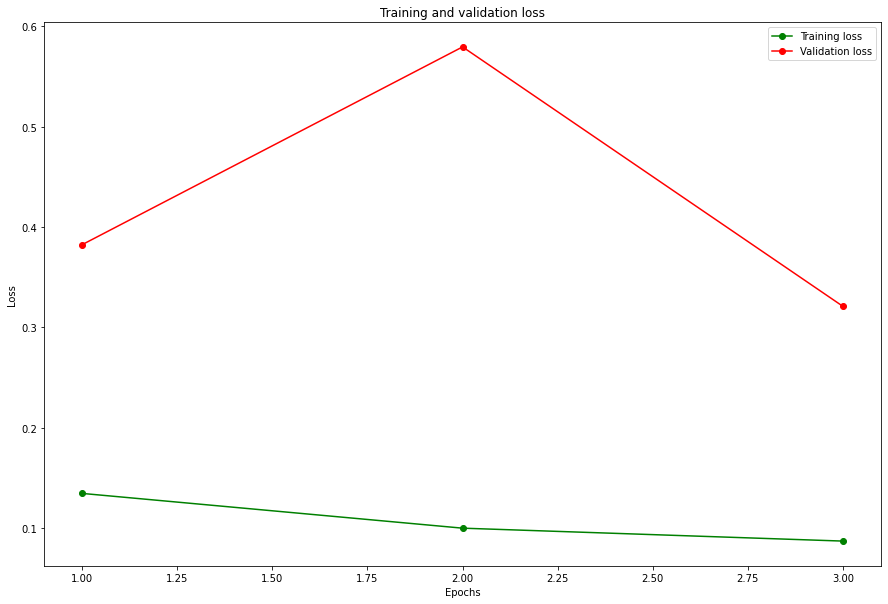

In [30]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(15,10))
plt.plot(epochs, loss, 'green', label='Training loss', marker = 'o')
plt.plot(epochs, val_loss, 'r', label='Validation loss', marker = 'o')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.savefig('loss_graph.png')
plt.show()

In [31]:
acc = history.history['one_hot_io_u']
val_acc = history.history['val_one_hot_io_u']

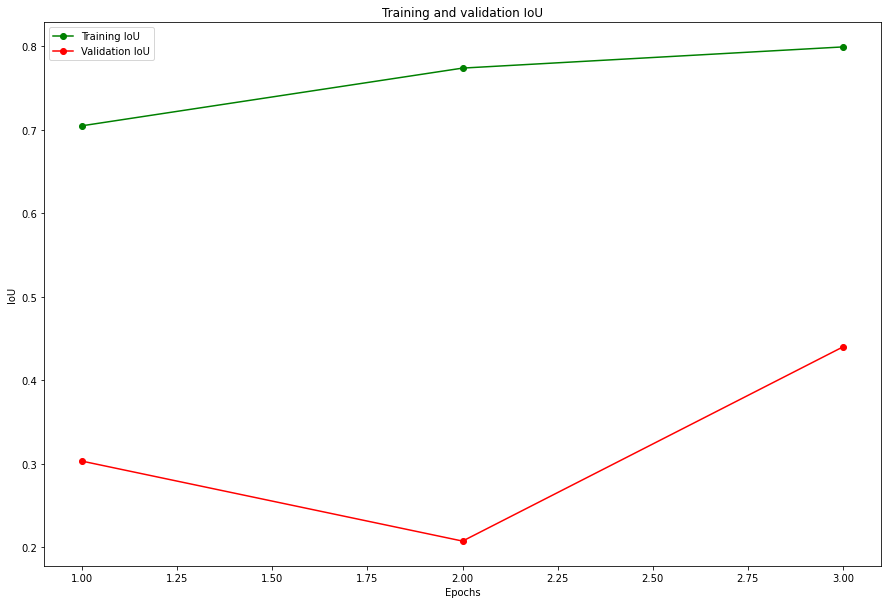

In [32]:
plt.figure(figsize=(15,10))
plt.plot(epochs, acc, 'green', label='Training IoU', marker = 'o')
plt.plot(epochs, val_acc, 'r', label='Validation IoU', marker = 'o')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
# plt.savefig('auccuracy_graph.png')
plt.show()

In [33]:
from keras.models import load_model

model = load_model(filepath, compile=False)

In [34]:
from tensorflow.keras.metrics import MeanIoU

In [35]:
test_image_batch, test_mask_batch = next(iter(valid_dataset))

#Convert categorical to integer for visualization and IoU calculation
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3) 
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 2s 2s/step


Mean IoU =

0.55466616

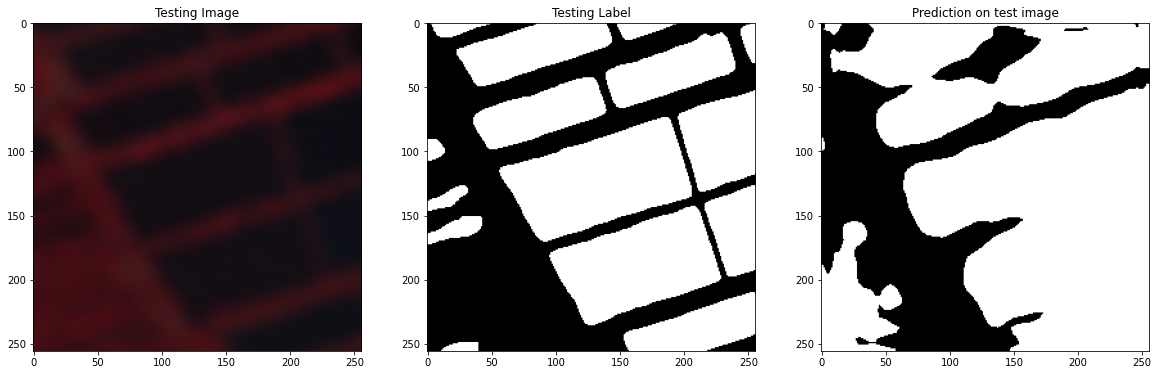

In [36]:
img_num = random.randint(0, test_image_batch.shape[0]-1)
image = test_image_batch[img_num]
plt.figure(figsize=(20,20))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(image[:,:,0:3])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_batch_argmax[img_num], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_pred_batch_argmax[img_num], cmap='gray')
plt.show()

In [37]:
No_of_valid_data = int(number_of_shards*filespershard*0.3)

In [38]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay,classification_report

In [39]:
test_image_batch, test_mask_batch = next(iter(valid_dataset.unbatch().batch(No_of_valid_data)))
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3) 
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)

 1/71 [..............................] - ETA: 1:02

 3/71 [>.............................] - ETA: 2s  

 4/71 [>.............................] - ETA: 3s

 5/71 [=>............................] - ETA: 3s

 6/71 [=>............................] - ETA: 3s

 7/71 [=>............................] - ETA: 3s

 8/71 [==>...........................] - ETA: 3s

 9/71 [==>...........................] - ETA: 3s

10/71 [===>..........................] - ETA: 3s

11/71 [===>..........................] - ETA: 3s

12/71 [====>.........................] - ETA: 3s

13/71 [====>.........................] - ETA: 3s

14/71 [====>.........................] - ETA: 3s

15/71 [=====>........................] - ETA: 3s

16/71 [=====>........................] - ETA: 3s

17/71 [======>.......................] - ETA: 3s

18/71 [======>.......................] - ETA: 3s

19/71 [=======>......................] - ETA: 3s

20/71 [=======>......................] - ETA: 3s

21/71 [=======>......................] - ETA: 3s

22/71 [========>.....................] - ETA: 3s

23/71 [========>.....................] - ETA: 2s

24/71 [=========>....................] - ETA: 2s

25/71 [=========>....................] - ETA: 2s

26/71 [=========>....................] - ETA: 2s

27/71 [==========>...................] - ETA: 2s

28/71 [==========>...................] - ETA: 2s

29/71 [===========>..................] - ETA: 2s

30/71 [===========>..................] - ETA: 2s

31/71 [============>.................] - ETA: 2s

32/71 [============>.................] - ETA: 2s

33/71 [============>.................] - ETA: 2s

34/71 [=============>................] - ETA: 2s

35/71 [=============>................] - ETA: 2s

36/71 [==============>...............] - ETA: 2s

37/71 [==============>...............] - ETA: 2s

38/71 [===============>..............] - ETA: 2s

39/71 [===============>..............] - ETA: 2s

40/71 [===============>..............] - ETA: 1s

41/71 [================>.............] - ETA: 1s

42/71 [================>.............] - ETA: 1s

43/71 [=================>............] - ETA: 1s

44/71 [=================>............] - ETA: 1s

45/71 [==================>...........] - ETA: 1s

46/71 [==================>...........] - ETA: 1s

47/71 [==================>...........] - ETA: 1s

48/71 [===================>..........] - ETA: 1s

49/71 [===================>..........] - ETA: 1s

50/71 [====================>.........] - ETA: 1s

51/71 [====================>.........] - ETA: 1s

52/71 [====================>.........] - ETA: 1s

53/71 [=====================>........] - ETA: 1s

54/71 [=====================>........] - ETA: 1s

55/71 [======================>.......] - ETA: 1s

56/71 [======================>.......] - ETA: 0s

57/71 [=======================>......] - ETA: 0s

58/71 [=======================>......] - ETA: 0s

59/71 [=======================>......] - ETA: 0s

60/71 [========================>.....] - ETA: 0s

61/71 [========================>.....] - ETA: 0s

62/71 [=========================>....] - ETA: 0s

63/71 [=========================>....] - ETA: 0s

64/71 [==========================>...] - ETA: 0s

65/71 [==========================>...] - ETA: 0s

66/71 [==========================>...] - ETA: 0s

67/71 [===========================>..] - ETA: 0s

68/71 [===========================>..] - ETA: 0s

69/71 [============================>.] - ETA: 0s

70/71 [============================>.] - ETA: 0s

71/71 [==============================] - ETA: 0s

71/71 [==============================] - 6s 70ms/step


In [40]:
cm = confusion_matrix(test_mask_batch_argmax.flatten(),test_pred_batch_argmax.flatten())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['non_ponds','ponds'])

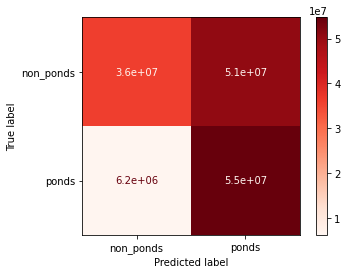

In [41]:
disp.plot(cmap=plt.cm.Reds)
plt.savefig('confusion_matrix.png')
plt.show()